# Policy gradients


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.2266490453171675 -2.4357471017977614
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [46]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [47]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [48]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [50]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits,
                                                                    labels=reward*tf.ones_like(Qs_logits)))
    # tf.nn.sigmoid(1+0.99*(Qs_logits)) --> tf.ones_like(Qs_logits) if Qs_logits >> 1
    #Qs_label = targetQs[1:]
    # g_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits,
    #                                                                  labels=tf.ones_like(Qs_logits)))
    g_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits[:-1],
                                                                     labels=tf.reshape(
                                                                         tf.nn.sigmoid(targetQs[1:]), 
                                                                         shape=[-1, 1])))
    #g_lossP = tf.reduce_mean(neg_log_prob_actions * tf.nn.sigmoid(targetQs))
    #g_lossP = tf.reduce_mean(neg_log_prob_actions * targetQs)
    g_lossP = tf.reduce_mean(neg_log_prob_actions[:-1] * targetQs[1:])
    #g_loss = g_lossQ + g_lossP
    g_loss = g_lossP

    return actions_logits, Qs_logits, g_loss, d_loss, g_lossQ, g_lossP

In [51]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [52]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.g_lossQ, self.g_lossP = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, reward=self.reward) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [53]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(500, 4) actions:(500,)
action size:2


In [54]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [55]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [56]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [57]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(11111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/500 # success is 400 points
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_lossQ, g_lossP, g_loss, d_loss, _, _ = sess.run([model.g_lossQ, model.g_lossP, 
                                                           model.g_loss, model.d_loss, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.reward: rate,
                                                                       model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'glossQ:{:.4f}'.format(g_lossQ),
              'glossP:{:.4f}'.format(g_lossP),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:10.0000 glossQ:0.6860 glossP:-0.1304 gloss:-0.1304 dloss:0.6069
Episode:1 meanR:14.5000 glossQ:0.6859 glossP:-0.1018 gloss:-0.1018 dloss:0.6297
Episode:2 meanR:18.6667 glossQ:0.6817 glossP:-0.1248 gloss:-0.1248 dloss:0.6232
Episode:3 meanR:23.7500 glossQ:0.6817 glossP:-0.1310 gloss:-0.1310 dloss:0.6252
Episode:4 meanR:24.4000 glossQ:0.6930 glossP:-0.0255 gloss:-0.0255 dloss:0.6762
Episode:5 meanR:24.3333 glossQ:0.6927 glossP:-0.0431 gloss:-0.0431 dloss:0.6646
Episode:6 meanR:23.1429 glossQ:0.6922 glossP:-0.0589 gloss:-0.0589 dloss:0.6527
Episode:7 meanR:22.2500 glossQ:0.6913 glossP:-0.0817 gloss:-0.0817 dloss:0.6385
Episode:8 meanR:21.2222 glossQ:0.6897 glossP:-0.1123 gloss:-0.1123 dloss:0.6188
Episode:9 meanR:20.1000 glossQ:0.6874 glossP:-0.1446 gloss:-0.1446 dloss:0.5981
Episode:10 meanR:19.4545 glossQ:0.6848 glossP:-0.1745 gloss:-0.1745 dloss:0.5816
Episode:11 meanR:19.0000 glossQ:0.6814 glossP:-0.2088 gloss:-0.2088 dloss:0.5633
Episode:12 meanR:18.4615 glossQ:0.6772

Episode:103 meanR:48.1400 glossQ:0.3479 glossP:-1.4428 gloss:-1.4428 dloss:0.1883
Episode:104 meanR:48.0200 glossQ:0.3390 glossP:-1.4746 gloss:-1.4746 dloss:0.1813
Episode:105 meanR:47.9000 glossQ:0.3366 glossP:-1.4843 gloss:-1.4843 dloss:0.1689
Episode:106 meanR:47.8400 glossQ:0.3008 glossP:-1.6125 gloss:-1.6125 dloss:0.1502
Episode:107 meanR:47.8100 glossQ:0.3179 glossP:-1.5519 gloss:-1.5519 dloss:0.1663
Episode:108 meanR:47.8400 glossQ:0.3212 glossP:-1.5467 gloss:-1.5467 dloss:0.1798
Episode:109 meanR:47.8400 glossQ:0.2878 glossP:-1.6750 gloss:-1.6750 dloss:0.1459
Episode:110 meanR:47.8500 glossQ:0.3470 glossP:-1.4600 gloss:-1.4600 dloss:0.1787
Episode:111 meanR:48.5100 glossQ:0.3874 glossP:-1.3276 gloss:-1.3276 dloss:0.4527
Episode:112 meanR:48.5700 glossQ:0.4207 glossP:-1.2068 gloss:-1.2068 dloss:0.2247
Episode:113 meanR:48.6500 glossQ:0.4178 glossP:-1.2142 gloss:-1.2142 dloss:0.2267
Episode:114 meanR:48.6900 glossQ:0.3994 glossP:-1.2710 gloss:-1.2710 dloss:0.2040
Episode:115 mean

Episode:203 meanR:85.1100 glossQ:0.5078 glossP:-0.9514 gloss:-0.9514 dloss:1.2227
Episode:204 meanR:86.7700 glossQ:0.4830 glossP:-1.0262 gloss:-1.0262 dloss:0.7488
Episode:205 meanR:89.1800 glossQ:0.5178 glossP:-0.9152 gloss:-0.9152 dloss:0.9079
Episode:206 meanR:90.5500 glossQ:0.5123 glossP:-0.9325 gloss:-0.9325 dloss:0.6298
Episode:207 meanR:91.2900 glossQ:0.5114 glossP:-0.9341 gloss:-0.9341 dloss:0.4679
Episode:208 meanR:91.2300 glossQ:0.2335 glossP:-1.9979 gloss:-1.9979 dloss:0.1449
Episode:209 meanR:92.1800 glossQ:0.4854 glossP:-1.0218 gloss:-1.0218 dloss:0.5202
Episode:210 meanR:92.2500 glossQ:0.4770 glossP:-1.0467 gloss:-1.0467 dloss:0.2741
Episode:211 meanR:91.6600 glossQ:0.4759 glossP:-1.0510 gloss:-1.0510 dloss:0.2737
Episode:212 meanR:92.3700 glossQ:0.4787 glossP:-1.0472 gloss:-1.0472 dloss:0.4747
Episode:213 meanR:97.1800 glossQ:0.5149 glossP:-0.9227 gloss:-0.9227 dloss:1.5689
Episode:214 meanR:98.7900 glossQ:0.5228 glossP:-0.8931 gloss:-0.8931 dloss:0.6978
Episode:215 mean

Episode:310 meanR:65.4500 glossQ:0.3793 glossP:-1.3461 gloss:-1.3461 dloss:1.3681
Episode:311 meanR:65.7200 glossQ:0.3649 glossP:-1.4081 gloss:-1.4081 dloss:0.3242
Episode:312 meanR:65.2500 glossQ:0.3619 glossP:-1.4216 gloss:-1.4216 dloss:0.3008
Episode:313 meanR:60.6300 glossQ:0.3572 glossP:-1.4384 gloss:-1.4384 dloss:0.2826
Episode:314 meanR:59.3000 glossQ:0.3546 glossP:-1.4506 gloss:-1.4506 dloss:0.3038
Episode:315 meanR:58.9300 glossQ:0.3403 glossP:-1.5084 gloss:-1.5084 dloss:0.2607
Episode:316 meanR:58.5800 glossQ:0.3503 glossP:-1.4680 gloss:-1.4680 dloss:0.2732
Episode:317 meanR:57.3900 glossQ:0.3411 glossP:-1.5000 gloss:-1.5000 dloss:0.2757
Episode:318 meanR:52.6300 glossQ:0.3206 glossP:-1.5773 gloss:-1.5773 dloss:0.2157
Episode:319 meanR:51.6700 glossQ:0.3270 glossP:-1.5566 gloss:-1.5566 dloss:0.2710
Episode:320 meanR:50.5200 glossQ:0.3207 glossP:-1.5805 gloss:-1.5805 dloss:0.3061
Episode:321 meanR:50.3000 glossQ:0.3193 glossP:-1.5903 gloss:-1.5903 dloss:0.3075
Episode:322 mean

Episode:410 meanR:45.0400 glossQ:0.3390 glossP:-1.4901 gloss:-1.4901 dloss:0.6416
Episode:411 meanR:45.9000 glossQ:0.3465 glossP:-1.4765 gloss:-1.4765 dloss:0.6899
Episode:412 meanR:46.8800 glossQ:0.3206 glossP:-1.5821 gloss:-1.5821 dloss:0.7452
Episode:413 meanR:48.1200 glossQ:0.2994 glossP:-1.6538 gloss:-1.6538 dloss:0.8678
Episode:414 meanR:49.5700 glossQ:0.3093 glossP:-1.6135 gloss:-1.6135 dloss:0.9761
Episode:415 meanR:49.6500 glossQ:0.2526 glossP:-1.8601 gloss:-1.8601 dloss:0.2953
Episode:416 meanR:49.4800 glossQ:0.2849 glossP:-1.6869 gloss:-1.6869 dloss:0.1802
Episode:417 meanR:49.2800 glossQ:0.2811 glossP:-1.7018 gloss:-1.7018 dloss:0.1702
Episode:418 meanR:49.1600 glossQ:0.2694 glossP:-1.7475 gloss:-1.7475 dloss:0.1445
Episode:419 meanR:48.9400 glossQ:0.2558 glossP:-1.8076 gloss:-1.8076 dloss:0.1513
Episode:420 meanR:48.6400 glossQ:0.2448 glossP:-1.8570 gloss:-1.8570 dloss:0.1495
Episode:421 meanR:48.3100 glossQ:0.2393 glossP:-1.8892 gloss:-1.8892 dloss:0.1344
Episode:422 mean

Episode:511 meanR:45.2900 glossQ:0.1866 glossP:-2.1719 gloss:-2.1719 dloss:0.1162
Episode:512 meanR:44.2700 glossQ:0.3185 glossP:-1.5536 gloss:-1.5536 dloss:0.2728
Episode:513 meanR:43.2600 glossQ:0.3202 glossP:-1.5433 gloss:-1.5433 dloss:0.3753
Episode:514 meanR:42.1000 glossQ:0.3211 glossP:-1.5392 gloss:-1.5392 dloss:0.4238
Episode:515 meanR:46.6900 glossQ:0.3410 glossP:-1.4691 gloss:-1.4691 dloss:2.2381
Episode:516 meanR:51.5000 glossQ:0.3493 glossP:-1.4404 gloss:-1.4404 dloss:2.2010
Episode:517 meanR:53.4200 glossQ:0.3742 glossP:-1.3633 gloss:-1.3633 dloss:0.9555
Episode:518 meanR:55.7700 glossQ:0.3837 glossP:-1.3336 gloss:-1.3336 dloss:1.0893
Episode:519 meanR:57.6600 glossQ:0.4075 glossP:-1.2592 gloss:-1.2592 dloss:0.8908
Episode:520 meanR:58.9800 glossQ:0.4323 glossP:-1.1839 gloss:-1.1839 dloss:0.6675
Episode:521 meanR:60.2600 glossQ:0.4331 glossP:-1.1849 gloss:-1.1849 dloss:0.6448
Episode:522 meanR:61.2300 glossQ:0.4586 glossP:-1.1056 gloss:-1.1056 dloss:0.5896
Episode:523 mean

Episode:613 meanR:82.0600 glossQ:0.2002 glossP:-2.1683 gloss:-2.1683 dloss:0.1372
Episode:614 meanR:81.5800 glossQ:0.3725 glossP:-1.3946 gloss:-1.3946 dloss:0.2307
Episode:615 meanR:76.8100 glossQ:0.3369 glossP:-1.5225 gloss:-1.5225 dloss:0.2155
Episode:616 meanR:72.0200 glossQ:0.3520 glossP:-1.4658 gloss:-1.4658 dloss:0.2105
Episode:617 meanR:70.1800 glossQ:0.3504 glossP:-1.4709 gloss:-1.4709 dloss:0.2250
Episode:618 meanR:68.1100 glossQ:0.4061 glossP:-1.2767 gloss:-1.2767 dloss:0.2991
Episode:619 meanR:66.5400 glossQ:0.3941 glossP:-1.3164 gloss:-1.3164 dloss:0.3181
Episode:620 meanR:65.6000 glossQ:0.4397 glossP:-1.1585 gloss:-1.1585 dloss:0.3476
Episode:621 meanR:64.7600 glossQ:0.4387 glossP:-1.1613 gloss:-1.1613 dloss:0.3576
Episode:622 meanR:64.3800 glossQ:0.4391 glossP:-1.1572 gloss:-1.1572 dloss:0.4679
Episode:623 meanR:67.6100 glossQ:0.4287 glossP:-1.1915 gloss:-1.1915 dloss:1.8880
Episode:624 meanR:67.7700 glossQ:0.4708 glossP:-1.0583 gloss:-1.0583 dloss:0.6357
Episode:625 mean

Episode:714 meanR:91.0300 glossQ:0.5944 glossP:-0.6430 gloss:-0.6430 dloss:0.5157
Episode:715 meanR:91.6600 glossQ:0.5983 glossP:-0.6315 gloss:-0.6315 dloss:0.5045
Episode:716 meanR:92.2000 glossQ:0.5879 glossP:-0.6806 gloss:-0.6806 dloss:0.4737
Episode:717 meanR:92.8000 glossQ:0.5829 glossP:-0.6919 gloss:-0.6919 dloss:0.4927
Episode:718 meanR:93.4500 glossQ:0.5703 glossP:-0.7458 gloss:-0.7458 dloss:0.5234
Episode:719 meanR:93.8300 glossQ:0.5761 glossP:-0.7254 gloss:-0.7254 dloss:0.4796
Episode:720 meanR:93.9600 glossQ:0.5319 glossP:-0.8707 gloss:-0.8707 dloss:0.4169
Episode:721 meanR:93.9300 glossQ:0.5239 glossP:-0.8936 gloss:-0.8936 dloss:0.3798
Episode:722 meanR:93.5800 glossQ:0.5354 glossP:-0.8567 gloss:-0.8567 dloss:0.3894
Episode:723 meanR:89.1500 glossQ:0.5132 glossP:-0.9310 gloss:-0.9310 dloss:0.3888
Episode:724 meanR:88.2500 glossQ:0.4798 glossP:-1.0349 gloss:-1.0349 dloss:0.3640
Episode:725 meanR:87.7300 glossQ:0.4875 glossP:-1.0133 gloss:-1.0133 dloss:0.3776
Episode:726 mean

Episode:814 meanR:254.5700 glossQ:0.6068 glossP:0.5923 gloss:0.5923 dloss:1.0641
Episode:815 meanR:254.4500 glossQ:0.6078 glossP:0.5785 gloss:0.5785 dloss:1.0811
Episode:816 meanR:254.3900 glossQ:0.6155 glossP:0.5472 gloss:0.5472 dloss:1.0642
Episode:817 meanR:254.0800 glossQ:0.6239 glossP:0.5084 gloss:0.5084 dloss:1.0579
Episode:818 meanR:253.5300 glossQ:0.6230 glossP:0.5115 gloss:0.5115 dloss:1.0658
Episode:819 meanR:253.1800 glossQ:0.6352 glossP:0.4538 gloss:0.4538 dloss:1.0208
Episode:820 meanR:253.2000 glossQ:0.6300 glossP:0.4765 gloss:0.4765 dloss:1.0138
Episode:821 meanR:253.3200 glossQ:0.6506 glossP:0.3581 gloss:0.3581 dloss:0.9332
Episode:822 meanR:253.5800 glossQ:0.6546 glossP:0.3274 gloss:0.3274 dloss:0.8975
Episode:823 meanR:253.7600 glossQ:0.6632 glossP:0.2601 gloss:0.2601 dloss:0.8579
Episode:824 meanR:254.1800 glossQ:0.6640 glossP:0.2556 gloss:0.2556 dloss:0.8395
Episode:825 meanR:254.5400 glossQ:0.6744 glossP:0.1489 gloss:0.1489 dloss:0.7830
Episode:826 meanR:254.8300 g

Episode:921 meanR:103.7400 glossQ:0.3085 glossP:-1.6795 gloss:-1.6795 dloss:0.3357
Episode:922 meanR:103.3800 glossQ:0.3382 glossP:-1.4779 gloss:-1.4779 dloss:0.2957
Episode:923 meanR:102.9900 glossQ:0.3310 glossP:-1.5024 gloss:-1.5024 dloss:0.2645
Episode:924 meanR:102.3400 glossQ:0.3145 glossP:-1.5598 gloss:-1.5598 dloss:0.2352
Episode:925 meanR:101.6900 glossQ:0.3116 glossP:-1.5724 gloss:-1.5724 dloss:0.2169
Episode:926 meanR:101.0700 glossQ:0.2957 glossP:-1.6277 gloss:-1.6277 dloss:0.2462
Episode:927 meanR:100.1800 glossQ:0.2844 glossP:-1.6740 gloss:-1.6740 dloss:0.2407
Episode:928 meanR:98.6600 glossQ:0.2789 glossP:-1.6923 gloss:-1.6923 dloss:0.2495
Episode:929 meanR:96.7000 glossQ:0.2596 glossP:-1.7695 gloss:-1.7695 dloss:0.3509
Episode:930 meanR:92.0800 glossQ:0.2618 glossP:-1.7636 gloss:-1.7636 dloss:0.2696
Episode:931 meanR:88.1800 glossQ:0.2277 glossP:-1.9486 gloss:-1.9486 dloss:0.6815
Episode:932 meanR:83.3000 glossQ:0.1010 glossP:-2.7696 gloss:-2.7696 dloss:0.1193
Episode:9

Episode:1021 meanR:139.7900 glossQ:0.6187 glossP:-0.5545 gloss:-0.5545 dloss:0.5546
Episode:1022 meanR:140.9300 glossQ:0.6285 glossP:-0.5109 gloss:-0.5109 dloss:0.6345
Episode:1023 meanR:141.8600 glossQ:0.6179 glossP:-0.5591 gloss:-0.5591 dloss:0.5901
Episode:1024 meanR:143.0900 glossQ:0.6228 glossP:-0.5351 gloss:-0.5351 dloss:0.6279
Episode:1025 meanR:147.8300 glossQ:0.6454 glossP:-0.4421 gloss:-0.4421 dloss:1.0625
Episode:1026 meanR:148.6100 glossQ:0.6345 glossP:-0.4969 gloss:-0.4969 dloss:0.5613
Episode:1027 meanR:148.8400 glossQ:0.6059 glossP:-0.6136 gloss:-0.6136 dloss:0.4515
Episode:1028 meanR:153.5000 glossQ:0.6482 glossP:-0.4271 gloss:-0.4271 dloss:1.0483
Episode:1029 meanR:154.9400 glossQ:0.6155 glossP:-0.5684 gloss:-0.5684 dloss:0.6969
Episode:1030 meanR:156.3600 glossQ:0.6367 glossP:-0.4867 gloss:-0.4867 dloss:0.6592
Episode:1031 meanR:155.5200 glossQ:0.5914 glossP:-0.6702 gloss:-0.6702 dloss:0.3854
Episode:1032 meanR:155.9100 glossQ:0.6065 glossP:-0.6064 gloss:-0.6064 dloss

Episode:1119 meanR:81.0800 glossQ:0.4504 glossP:-1.1719 gloss:-1.1719 dloss:0.3344
Episode:1120 meanR:79.9600 glossQ:0.4380 glossP:-1.2065 gloss:-1.2065 dloss:0.3343
Episode:1121 meanR:79.0400 glossQ:0.1857 glossP:-2.2742 gloss:-2.2742 dloss:0.1462
Episode:1122 meanR:77.8300 glossQ:0.4218 glossP:-1.2720 gloss:-1.2720 dloss:0.3010
Episode:1123 meanR:76.8200 glossQ:0.3641 glossP:-1.4796 gloss:-1.4796 dloss:0.2479
Episode:1124 meanR:75.6200 glossQ:0.3861 glossP:-1.4164 gloss:-1.4164 dloss:0.2822
Episode:1125 meanR:71.8400 glossQ:0.3456 glossP:-1.5286 gloss:-1.5286 dloss:0.6559
Episode:1126 meanR:70.9200 glossQ:0.2377 glossP:-2.1003 gloss:-2.1003 dloss:0.1946
Episode:1127 meanR:70.7300 glossQ:0.3453 glossP:-1.5862 gloss:-1.5862 dloss:0.2879
Episode:1128 meanR:66.1800 glossQ:0.3851 glossP:-1.4046 gloss:-1.4046 dloss:0.3264
Episode:1129 meanR:65.0000 glossQ:0.3879 glossP:-1.3690 gloss:-1.3690 dloss:0.4570
Episode:1130 meanR:64.2000 glossQ:0.3865 glossP:-1.3672 gloss:-1.3672 dloss:0.5353
Epis

Episode:1218 meanR:112.4800 glossQ:0.5487 glossP:-0.8251 gloss:-0.8251 dloss:0.5662
Episode:1219 meanR:113.1100 glossQ:0.5517 glossP:-0.8171 gloss:-0.8171 dloss:0.5327
Episode:1220 meanR:113.1400 glossQ:0.4864 glossP:-1.0313 gloss:-1.0313 dloss:0.3573
Episode:1221 meanR:114.6000 glossQ:0.5462 glossP:-0.8270 gloss:-0.8270 dloss:0.6598
Episode:1222 meanR:115.1600 glossQ:0.5220 glossP:-0.9154 gloss:-0.9154 dloss:0.4951
Episode:1223 meanR:116.5200 glossQ:0.5310 glossP:-0.8806 gloss:-0.8806 dloss:0.6811
Episode:1224 meanR:117.3500 glossQ:0.5295 glossP:-0.8907 gloss:-0.8907 dloss:0.5596
Episode:1225 meanR:116.5900 glossQ:0.4494 glossP:-1.1520 gloss:-1.1520 dloss:0.3408
Episode:1226 meanR:116.5700 glossQ:0.3951 glossP:-1.3317 gloss:-1.3317 dloss:0.2197
Episode:1227 meanR:116.4000 glossQ:0.3812 glossP:-1.3824 gloss:-1.3824 dloss:0.2218
Episode:1228 meanR:116.0600 glossQ:0.3097 glossP:-1.6435 gloss:-1.6435 dloss:0.1726
Episode:1229 meanR:115.3700 glossQ:0.2731 glossP:-1.8152 gloss:-1.8152 dloss

Episode:1316 meanR:159.2800 glossQ:0.6527 glossP:-0.4098 gloss:-0.4098 dloss:1.0329
Episode:1317 meanR:162.8800 glossQ:0.6408 glossP:-0.4783 gloss:-0.4783 dloss:1.1003
Episode:1318 meanR:161.9400 glossQ:0.5068 glossP:-0.9479 gloss:-0.9479 dloss:0.3331
Episode:1319 meanR:160.9600 glossQ:0.4101 glossP:-1.3023 gloss:-1.3023 dloss:0.2517
Episode:1320 meanR:165.4800 glossQ:0.6602 glossP:-0.3674 gloss:-0.3674 dloss:0.9944
Episode:1321 meanR:166.2800 glossQ:0.6549 glossP:-0.3752 gloss:-0.3752 dloss:0.7235
Episode:1322 meanR:167.1400 glossQ:0.6628 glossP:-0.3254 gloss:-0.3254 dloss:0.6595
Episode:1323 meanR:165.9400 glossQ:0.6438 glossP:-0.4584 gloss:-0.4584 dloss:0.4803
Episode:1324 meanR:165.1300 glossQ:0.6392 glossP:-0.4895 gloss:-0.4895 dloss:0.4567
Episode:1325 meanR:165.0300 glossQ:0.6450 glossP:-0.4539 gloss:-0.4539 dloss:0.4718
Episode:1326 meanR:165.1900 glossQ:0.6394 glossP:-0.4898 gloss:-0.4898 dloss:0.4545
Episode:1327 meanR:165.3300 glossQ:0.6424 glossP:-0.4766 gloss:-0.4766 dloss

Episode:1416 meanR:117.6800 glossQ:0.5872 glossP:-0.6844 gloss:-0.6844 dloss:0.7111
Episode:1417 meanR:117.6800 glossQ:0.6375 glossP:-0.4999 gloss:-0.4999 dloss:1.1241
Episode:1418 meanR:122.4200 glossQ:0.6553 glossP:-0.4061 gloss:-0.4061 dloss:1.0302
Episode:1419 meanR:127.3300 glossQ:0.6580 glossP:-0.3908 gloss:-0.3908 dloss:1.0155
Episode:1420 meanR:127.3300 glossQ:0.6577 glossP:-0.3957 gloss:-0.3957 dloss:1.0205
Episode:1421 meanR:129.9400 glossQ:0.6568 glossP:-0.4014 gloss:-0.4014 dloss:1.0270
Episode:1422 meanR:133.1600 glossQ:0.6481 glossP:-0.4638 gloss:-0.4638 dloss:1.0885
Episode:1423 meanR:137.7200 glossQ:0.6476 glossP:-0.4662 gloss:-0.4662 dloss:1.0916
Episode:1424 meanR:142.3700 glossQ:0.6426 glossP:-0.4835 gloss:-0.4835 dloss:1.1107
Episode:1425 meanR:147.0100 glossQ:0.6495 glossP:-0.4597 gloss:-0.4597 dloss:1.0863
Episode:1426 meanR:147.7700 glossQ:0.6228 glossP:-0.5682 gloss:-0.5682 dloss:0.5829
Episode:1427 meanR:147.7700 glossQ:0.5649 glossP:-0.7969 gloss:-0.7969 dloss

Episode:1517 meanR:375.1500 glossQ:0.5922 glossP:0.5492 gloss:0.5492 dloss:1.0089
Episode:1518 meanR:371.7700 glossQ:0.5950 glossP:0.5567 gloss:0.5567 dloss:0.9493
Episode:1519 meanR:368.4000 glossQ:0.5624 glossP:0.6627 gloss:0.6627 dloss:1.0141
Episode:1520 meanR:364.9700 glossQ:0.5877 glossP:0.5081 gloss:0.5081 dloss:0.9537
Episode:1521 meanR:361.4900 glossQ:0.5868 glossP:0.5414 gloss:0.5414 dloss:0.9705
Episode:1522 meanR:357.6000 glossQ:0.6327 glossP:0.3478 gloss:0.3478 dloss:0.9045
Episode:1523 meanR:353.8800 glossQ:0.6316 glossP:0.3274 gloss:0.3274 dloss:0.8804
Episode:1524 meanR:350.0000 glossQ:0.6459 glossP:0.2118 gloss:0.2118 dloss:0.8342
Episode:1525 meanR:346.7000 glossQ:0.6180 glossP:0.3283 gloss:0.3283 dloss:0.8532
Episode:1526 meanR:346.7800 glossQ:0.6543 glossP:0.1566 gloss:0.1566 dloss:0.8000
Episode:1527 meanR:347.5700 glossQ:0.6621 glossP:0.0738 gloss:0.0738 dloss:0.7617
Episode:1528 meanR:348.7700 glossQ:0.6559 glossP:0.0761 gloss:0.0761 dloss:0.7632
Episode:1529 mea

Episode:1617 meanR:77.4400 glossQ:0.2984 glossP:-1.6992 gloss:-1.6992 dloss:0.2792
Episode:1618 meanR:76.3700 glossQ:0.3237 glossP:-1.5946 gloss:-1.5946 dloss:0.3588
Episode:1619 meanR:75.5700 glossQ:0.3486 glossP:-1.4896 gloss:-1.4896 dloss:0.4766
Episode:1620 meanR:75.0600 glossQ:0.3287 glossP:-1.5678 gloss:-1.5678 dloss:0.5893
Episode:1621 meanR:74.1500 glossQ:0.2983 glossP:-1.7030 gloss:-1.7030 dloss:0.3962
Episode:1622 meanR:73.6100 glossQ:0.3113 glossP:-1.6473 gloss:-1.6473 dloss:0.3740
Episode:1623 meanR:72.8100 glossQ:0.2885 glossP:-1.7569 gloss:-1.7569 dloss:0.3356
Episode:1624 meanR:72.0000 glossQ:0.2567 glossP:-1.9089 gloss:-1.9089 dloss:0.2496
Episode:1625 meanR:70.5700 glossQ:0.2436 glossP:-1.9593 gloss:-1.9593 dloss:0.2251
Episode:1626 meanR:69.8300 glossQ:0.2162 glossP:-2.3799 gloss:-2.3799 dloss:0.3594
Episode:1627 meanR:69.2700 glossQ:0.2502 glossP:-2.1146 gloss:-2.1146 dloss:0.4193
Episode:1628 meanR:68.1500 glossQ:0.1946 glossP:-2.1219 gloss:-2.1219 dloss:0.1755
Epis

Episode:1719 meanR:130.7000 glossQ:0.6151 glossP:-0.5722 gloss:-0.5722 dloss:0.4293
Episode:1720 meanR:129.9400 glossQ:0.6217 glossP:-0.5432 gloss:-0.5432 dloss:0.4415
Episode:1721 meanR:129.5100 glossQ:0.6046 glossP:-0.6190 gloss:-0.6190 dloss:0.4009
Episode:1722 meanR:129.1400 glossQ:0.6035 glossP:-0.6226 gloss:-0.6226 dloss:0.4023
Episode:1723 meanR:128.8400 glossQ:0.5759 glossP:-0.7283 gloss:-0.7283 dloss:0.3631
Episode:1724 meanR:128.7000 glossQ:0.5763 glossP:-0.7288 gloss:-0.7288 dloss:0.3648
Episode:1725 meanR:128.5600 glossQ:0.5222 glossP:-0.9099 gloss:-0.9099 dloss:0.3104
Episode:1726 meanR:128.3000 glossQ:0.5390 glossP:-0.8551 gloss:-0.8551 dloss:0.3290
Episode:1727 meanR:127.9400 glossQ:0.5557 glossP:-0.8066 gloss:-0.8066 dloss:0.3477
Episode:1728 meanR:127.9900 glossQ:0.5471 glossP:-0.8366 gloss:-0.8366 dloss:0.3427
Episode:1729 meanR:127.9800 glossQ:0.5147 glossP:-0.9407 gloss:-0.9407 dloss:0.3091
Episode:1730 meanR:127.9300 glossQ:0.4936 glossP:-1.0154 gloss:-1.0154 dloss

Episode:1818 meanR:253.3800 glossQ:0.6853 glossP:0.1618 gloss:0.1618 dloss:0.6276
Episode:1819 meanR:258.1000 glossQ:0.6879 glossP:0.1382 gloss:0.1382 dloss:0.5986
Episode:1820 meanR:262.8000 glossQ:0.6893 glossP:0.1224 gloss:0.1224 dloss:0.6086
Episode:1821 meanR:266.6100 glossQ:0.6833 glossP:0.1874 gloss:0.1874 dloss:0.6224
Episode:1822 meanR:269.1800 glossQ:0.6816 glossP:0.1976 gloss:0.1976 dloss:0.6895
Episode:1823 meanR:274.0000 glossQ:0.6841 glossP:0.1827 gloss:0.1827 dloss:0.5700
Episode:1824 meanR:278.8300 glossQ:0.6893 glossP:0.1226 gloss:0.1226 dloss:0.6086
Episode:1825 meanR:283.7000 glossQ:0.6846 glossP:0.1795 gloss:0.1795 dloss:0.5719
Episode:1826 meanR:288.5300 glossQ:0.6872 glossP:0.1512 gloss:0.1512 dloss:0.5898
Episode:1827 meanR:293.3300 glossQ:0.6864 glossP:0.1613 gloss:0.1613 dloss:0.5833
Episode:1828 meanR:298.0600 glossQ:0.6789 glossP:0.2271 gloss:0.2271 dloss:0.5444
Episode:1829 meanR:302.8800 glossQ:0.6850 glossP:0.1770 gloss:0.1770 dloss:0.5733
Episode:1830 mea

Episode:1917 meanR:270.8700 glossQ:0.6860 glossP:0.0411 gloss:0.0411 dloss:0.6715
Episode:1918 meanR:271.8000 glossQ:0.6905 glossP:0.0620 gloss:0.0620 dloss:0.6513
Episode:1919 meanR:271.8000 glossQ:0.6899 glossP:0.1159 gloss:0.1159 dloss:0.6127
Episode:1920 meanR:271.8000 glossQ:0.6902 glossP:0.1134 gloss:0.1134 dloss:0.6146
Episode:1921 meanR:272.8100 glossQ:0.6892 glossP:0.1075 gloss:0.1075 dloss:0.6197
Episode:1922 meanR:275.0400 glossQ:0.6875 glossP:0.1138 gloss:0.1138 dloss:0.6168
Episode:1923 meanR:275.0400 glossQ:0.6836 glossP:0.1277 gloss:0.1277 dloss:0.6108
Episode:1924 meanR:275.0400 glossQ:0.6870 glossP:0.1328 gloss:0.1328 dloss:0.6036
Episode:1925 meanR:275.0400 glossQ:0.6821 glossP:0.1492 gloss:0.1492 dloss:0.5968
Episode:1926 meanR:275.0400 glossQ:0.6825 glossP:0.1849 gloss:0.1849 dloss:0.5704
Episode:1927 meanR:275.0400 glossQ:0.6798 glossP:0.2276 gloss:0.2276 dloss:0.5418
Episode:1928 meanR:275.0600 glossQ:0.6842 glossP:0.1339 gloss:0.1339 dloss:0.6069
Episode:1929 mea

Episode:2018 meanR:297.1400 glossQ:0.6726 glossP:0.1527 gloss:0.1527 dloss:0.7273
Episode:2019 meanR:294.7100 glossQ:0.6748 glossP:0.2022 gloss:0.2022 dloss:0.7098
Episode:2020 meanR:292.1900 glossQ:0.6774 glossP:0.1850 gloss:0.1850 dloss:0.7125
Episode:2021 meanR:289.3300 glossQ:0.6748 glossP:0.1819 gloss:0.1819 dloss:0.7333
Episode:2022 meanR:286.6900 glossQ:0.6619 glossP:0.2511 gloss:0.2511 dloss:0.7377
Episode:2023 meanR:284.3400 glossQ:0.6647 glossP:0.2668 gloss:0.2668 dloss:0.7123
Episode:2024 meanR:282.8300 glossQ:0.6525 glossP:0.2654 gloss:0.2654 dloss:0.6603
Episode:2025 meanR:280.3100 glossQ:0.6742 glossP:0.2119 gloss:0.2119 dloss:0.7153
Episode:2026 meanR:277.4900 glossQ:0.6778 glossP:0.0913 gloss:0.0913 dloss:0.7195
Episode:2027 meanR:274.8500 glossQ:0.6816 glossP:0.1037 gloss:0.1037 dloss:0.7112
Episode:2028 meanR:273.2200 glossQ:0.6731 glossP:0.1900 gloss:0.1900 dloss:0.6664
Episode:2029 meanR:273.3200 glossQ:0.6673 glossP:0.2143 gloss:0.2143 dloss:0.6383
Episode:2030 mea

Episode:2118 meanR:276.9200 glossQ:0.6920 glossP:0.0217 gloss:0.0217 dloss:0.7011
Episode:2119 meanR:276.7300 glossQ:0.6879 glossP:0.0569 gloss:0.0569 dloss:0.7025
Episode:2120 meanR:276.7800 glossQ:0.6864 glossP:0.0874 gloss:0.0874 dloss:0.7000
Episode:2121 meanR:278.0000 glossQ:0.6837 glossP:0.1194 gloss:0.1194 dloss:0.6650
Episode:2122 meanR:278.1300 glossQ:0.6904 glossP:0.0612 gloss:0.0612 dloss:0.6973
Episode:2123 meanR:278.2300 glossQ:0.6828 glossP:0.0920 gloss:0.0920 dloss:0.6952
Episode:2124 meanR:277.5300 glossQ:0.6879 glossP:0.0919 gloss:0.0919 dloss:0.6885
Episode:2125 meanR:279.7500 glossQ:0.6770 glossP:0.1643 gloss:0.1643 dloss:0.5660
Episode:2126 meanR:280.7300 glossQ:0.6830 glossP:0.1130 gloss:0.1130 dloss:0.6733
Episode:2127 meanR:281.7600 glossQ:0.6789 glossP:0.1226 gloss:0.1226 dloss:0.6623
Episode:2128 meanR:283.3900 glossQ:0.6705 glossP:0.1831 gloss:0.1831 dloss:0.5273
Episode:2129 meanR:284.5700 glossQ:0.6697 glossP:0.1678 gloss:0.1678 dloss:0.5365
Episode:2130 mea

Episode:2217 meanR:143.6300 glossQ:0.5391 glossP:-0.8619 gloss:-0.8619 dloss:0.3178
Episode:2218 meanR:141.9000 glossQ:0.4979 glossP:-0.9877 gloss:-0.9877 dloss:0.2735
Episode:2219 meanR:139.6800 glossQ:0.4758 glossP:-1.0665 gloss:-1.0665 dloss:0.2575
Episode:2220 meanR:137.3600 glossQ:0.4538 glossP:-1.1369 gloss:-1.1369 dloss:0.2594
Episode:2221 meanR:134.2100 glossQ:0.4229 glossP:-1.2353 gloss:-1.2353 dloss:0.2449
Episode:2222 meanR:131.8600 glossQ:0.3591 glossP:-1.4359 gloss:-1.4359 dloss:0.1943
Episode:2223 meanR:129.3000 glossQ:0.3622 glossP:-1.4427 gloss:-1.4427 dloss:0.2142
Episode:2224 meanR:126.7100 glossQ:0.3260 glossP:-1.5868 gloss:-1.5868 dloss:0.2113
Episode:2225 meanR:122.2000 glossQ:0.3026 glossP:-1.7003 gloss:-1.7003 dloss:0.2031
Episode:2226 meanR:119.1800 glossQ:0.2483 glossP:-1.9084 gloss:-1.9084 dloss:0.1642
Episode:2227 meanR:115.9200 glossQ:0.2064 glossP:-2.1445 gloss:-2.1445 dloss:0.1540
Episode:2228 meanR:111.0800 glossQ:0.1837 glossP:-2.3330 gloss:-2.3330 dloss

Episode:2316 meanR:137.5200 glossQ:0.6664 glossP:-0.2137 gloss:-0.2137 dloss:0.7035
Episode:2317 meanR:139.6700 glossQ:0.6686 glossP:-0.2050 gloss:-0.2050 dloss:0.7147
Episode:2318 meanR:141.9900 glossQ:0.6699 glossP:-0.2017 gloss:-0.2017 dloss:0.7212
Episode:2319 meanR:144.2500 glossQ:0.6733 glossP:-0.1825 gloss:-0.1825 dloss:0.7135
Episode:2320 meanR:146.4900 glossQ:0.6716 glossP:-0.2025 gloss:-0.2025 dloss:0.7179
Episode:2321 meanR:148.9700 glossQ:0.6747 glossP:-0.1885 gloss:-0.1885 dloss:0.7280
Episode:2322 meanR:151.6100 glossQ:0.6735 glossP:-0.1912 gloss:-0.1912 dloss:0.7361
Episode:2323 meanR:154.3300 glossQ:0.6756 glossP:-0.1577 gloss:-0.1577 dloss:0.7350
Episode:2324 meanR:156.8700 glossQ:0.6736 glossP:-0.1741 gloss:-0.1741 dloss:0.7313
Episode:2325 meanR:159.4300 glossQ:0.6783 glossP:-0.1321 gloss:-0.1321 dloss:0.7219
Episode:2326 meanR:162.2000 glossQ:0.6769 glossP:-0.1236 gloss:-0.1236 dloss:0.7290
Episode:2327 meanR:164.9300 glossQ:0.6792 glossP:-0.1035 gloss:-0.1035 dloss

Episode:2416 meanR:269.9400 glossQ:0.6687 glossP:-0.1937 gloss:-0.1937 dloss:0.6739
Episode:2417 meanR:269.2300 glossQ:0.6642 glossP:-0.2246 gloss:-0.2246 dloss:0.6642
Episode:2418 meanR:268.8200 glossQ:0.6676 glossP:-0.2068 gloss:-0.2068 dloss:0.6962
Episode:2419 meanR:267.9600 glossQ:0.6554 glossP:-0.2794 gloss:-0.2794 dloss:0.6516
Episode:2420 meanR:266.9600 glossQ:0.6495 glossP:-0.3093 gloss:-0.3093 dloss:0.6390
Episode:2421 meanR:265.9800 glossQ:0.6527 glossP:-0.2773 gloss:-0.2773 dloss:0.6697
Episode:2422 meanR:265.2600 glossQ:0.6565 glossP:-0.2658 gloss:-0.2658 dloss:0.7004
Episode:2423 meanR:263.8000 glossQ:0.6382 glossP:-0.3646 gloss:-0.3646 dloss:0.6364
Episode:2424 meanR:262.6500 glossQ:0.6384 glossP:-0.3454 gloss:-0.3454 dloss:0.6586
Episode:2425 meanR:261.6200 glossQ:0.6390 glossP:-0.3451 gloss:-0.3451 dloss:0.6734
Episode:2426 meanR:260.6200 glossQ:0.6408 glossP:-0.3323 gloss:-0.3323 dloss:0.6958
Episode:2427 meanR:259.1500 glossQ:0.6254 glossP:-0.4232 gloss:-0.4232 dloss

Episode:2514 meanR:138.9700 glossQ:0.6439 glossP:-0.4363 gloss:-0.4363 dloss:0.7790
Episode:2515 meanR:139.4600 glossQ:0.6538 glossP:-0.4056 gloss:-0.4056 dloss:0.7122
Episode:2516 meanR:139.8700 glossQ:0.6531 glossP:-0.3930 gloss:-0.3930 dloss:0.7083
Episode:2517 meanR:140.3200 glossQ:0.5942 glossP:-0.6178 gloss:-0.6178 dloss:0.7599
Episode:2518 meanR:139.8200 glossQ:0.6448 glossP:-0.4220 gloss:-0.4220 dloss:0.6462
Episode:2519 meanR:140.2500 glossQ:0.6158 glossP:-0.5144 gloss:-0.5144 dloss:0.7139
Episode:2520 meanR:139.7000 glossQ:0.5513 glossP:-0.7920 gloss:-0.7920 dloss:0.4964
Episode:2521 meanR:139.7000 glossQ:0.6179 glossP:-0.4994 gloss:-0.4994 dloss:0.6709
Episode:2522 meanR:138.4100 glossQ:0.6102 glossP:-0.5818 gloss:-0.5818 dloss:0.5081
Episode:2523 meanR:138.4400 glossQ:0.6657 glossP:-0.3184 gloss:-0.3184 dloss:0.6412
Episode:2524 meanR:138.8600 glossQ:0.6370 glossP:-0.4109 gloss:-0.4109 dloss:0.7024
Episode:2525 meanR:138.5200 glossQ:0.6493 glossP:-0.3973 gloss:-0.3973 dloss

Episode:2615 meanR:286.5100 glossQ:0.6477 glossP:-0.1236 gloss:-0.1236 dloss:0.6828
Episode:2616 meanR:284.8400 glossQ:0.6371 glossP:-0.3475 gloss:-0.3475 dloss:0.5553
Episode:2617 meanR:283.1900 glossQ:0.6385 glossP:-0.3250 gloss:-0.3250 dloss:0.5657
Episode:2618 meanR:282.0000 glossQ:0.6101 glossP:-0.5053 gloss:-0.5053 dloss:0.4759
Episode:2619 meanR:280.3800 glossQ:0.6053 glossP:-0.5308 gloss:-0.5308 dloss:0.4651
Episode:2620 meanR:279.9100 glossQ:0.6020 glossP:-0.5430 gloss:-0.5430 dloss:0.4719
Episode:2621 meanR:278.7700 glossQ:0.6266 glossP:-0.3944 gloss:-0.3944 dloss:0.5513
Episode:2622 meanR:278.4600 glossQ:0.5923 glossP:-0.5781 gloss:-0.5781 dloss:0.4704
Episode:2623 meanR:277.8700 glossQ:0.6397 glossP:-0.1427 gloss:-0.1427 dloss:0.6976
Episode:2624 meanR:276.2800 glossQ:0.5632 glossP:-0.7027 gloss:-0.7027 dloss:0.4265
Episode:2625 meanR:275.4900 glossQ:0.5951 glossP:-0.5530 gloss:-0.5530 dloss:0.5101
Episode:2626 meanR:275.8000 glossQ:0.5411 glossP:-0.7874 gloss:-0.7874 dloss

Episode:2714 meanR:166.3500 glossQ:0.4893 glossP:0.8650 gloss:0.8650 dloss:0.9474
Episode:2715 meanR:168.8800 glossQ:0.5042 glossP:0.7544 gloss:0.7544 dloss:0.8049
Episode:2716 meanR:171.4300 glossQ:0.4670 glossP:0.6759 gloss:0.6759 dloss:0.9000
Episode:2717 meanR:172.8300 glossQ:0.4944 glossP:0.8507 gloss:0.8507 dloss:1.1617
Episode:2718 meanR:174.0900 glossQ:0.5209 glossP:0.7684 gloss:0.7684 dloss:1.1460
Episode:2719 meanR:175.5200 glossQ:0.5454 glossP:0.6671 gloss:0.6671 dloss:1.0500
Episode:2720 meanR:177.1800 glossQ:0.5639 glossP:0.5637 gloss:0.5637 dloss:0.9460
Episode:2721 meanR:178.3700 glossQ:0.5291 glossP:0.6876 gloss:0.6876 dloss:1.0847
Episode:2722 meanR:180.8700 glossQ:0.5580 glossP:0.5820 gloss:0.5820 dloss:0.7795
Episode:2723 meanR:181.9900 glossQ:0.5583 glossP:0.5598 gloss:0.5598 dloss:0.9616
Episode:2724 meanR:183.8200 glossQ:0.5733 glossP:0.5041 gloss:0.5041 dloss:0.8883
Episode:2725 meanR:185.9900 glossQ:0.6006 glossP:0.3848 gloss:0.3848 dloss:0.7713
Episode:2726 mea

Episode:2817 meanR:239.0000 glossQ:0.6205 glossP:-0.4931 gloss:-0.4931 dloss:0.4725
Episode:2818 meanR:237.7400 glossQ:0.6282 glossP:-0.4539 gloss:-0.4539 dloss:0.4983
Episode:2819 meanR:236.3000 glossQ:0.6247 glossP:-0.4651 gloss:-0.4651 dloss:0.4935
Episode:2820 meanR:234.4500 glossQ:0.5790 glossP:-0.6722 gloss:-0.6722 dloss:0.4017
Episode:2821 meanR:232.9600 glossQ:0.6053 glossP:-0.5667 gloss:-0.5667 dloss:0.4448
Episode:2822 meanR:230.3500 glossQ:0.6119 glossP:-0.5085 gloss:-0.5085 dloss:0.4874
Episode:2823 meanR:229.1700 glossQ:0.6567 glossP:-0.2618 gloss:-0.2618 dloss:0.6166
Episode:2824 meanR:227.4400 glossQ:0.6342 glossP:-0.3902 gloss:-0.3902 dloss:0.5563
Episode:2825 meanR:224.8100 glossQ:0.4140 glossP:-1.2321 gloss:-1.2321 dloss:0.2584
Episode:2826 meanR:223.2500 glossQ:0.6423 glossP:-0.3682 gloss:-0.3682 dloss:0.5839
Episode:2827 meanR:226.3400 glossQ:0.6892 glossP:-0.1795 gloss:-0.1795 dloss:0.8387
Episode:2828 meanR:228.9300 glossQ:0.6928 glossP:-0.1347 gloss:-0.1347 dloss

Episode:2918 meanR:115.8700 glossQ:0.3522 glossP:-1.4705 gloss:-1.4705 dloss:0.2265
Episode:2919 meanR:115.6400 glossQ:0.3517 glossP:-1.4828 gloss:-1.4828 dloss:0.2296
Episode:2920 meanR:115.5000 glossQ:0.3252 glossP:-1.6008 gloss:-1.6008 dloss:0.2043
Episode:2921 meanR:115.7500 glossQ:0.4770 glossP:-1.1091 gloss:-1.1091 dloss:0.4164
Episode:2922 meanR:115.8900 glossQ:0.4929 glossP:-1.0561 gloss:-1.0561 dloss:0.4139
Episode:2923 meanR:115.8300 glossQ:0.5850 glossP:-0.6913 gloss:-0.6913 dloss:0.5096
Episode:2924 meanR:116.2200 glossQ:0.5429 glossP:-0.8479 gloss:-0.8479 dloss:0.5374
Episode:2925 meanR:117.5200 glossQ:0.5811 glossP:-0.7346 gloss:-0.7346 dloss:0.6530
Episode:2926 meanR:119.1000 glossQ:0.6740 glossP:-0.2710 gloss:-0.2710 dloss:0.7089
Episode:2927 meanR:116.8200 glossQ:0.6710 glossP:-0.2944 gloss:-0.2944 dloss:0.7425
Episode:2928 meanR:115.5400 glossQ:0.6664 glossP:-0.3345 gloss:-0.3345 dloss:0.8474
Episode:2929 meanR:113.0900 glossQ:0.6674 glossP:-0.3200 gloss:-0.3200 dloss

Episode:3018 meanR:265.2700 glossQ:0.6887 glossP:0.0873 gloss:0.0873 dloss:0.7124
Episode:3019 meanR:268.5800 glossQ:0.6865 glossP:0.0810 gloss:0.0810 dloss:0.6777
Episode:3020 meanR:273.1600 glossQ:0.6876 glossP:0.0842 gloss:0.0842 dloss:0.6446
Episode:3021 meanR:275.6200 glossQ:0.6862 glossP:0.1349 gloss:0.1349 dloss:0.6808
Episode:3022 meanR:278.0900 glossQ:0.6864 glossP:0.1272 gloss:0.1272 dloss:0.6827
Episode:3023 meanR:279.9700 glossQ:0.6861 glossP:0.1113 gloss:0.1113 dloss:0.6957
Episode:3024 meanR:281.1100 glossQ:0.6887 glossP:0.0873 gloss:0.0873 dloss:0.7106
Episode:3025 meanR:284.1900 glossQ:0.6880 glossP:0.0741 gloss:0.0741 dloss:0.6546
Episode:3026 meanR:286.8500 glossQ:0.6921 glossP:0.0830 gloss:0.0830 dloss:0.6335
Episode:3027 meanR:289.1300 glossQ:0.6895 glossP:0.1142 gloss:0.1142 dloss:0.6117
Episode:3028 meanR:288.2400 glossQ:0.6868 glossP:0.1302 gloss:0.1302 dloss:0.6869
Episode:3029 meanR:290.2600 glossQ:0.6872 glossP:0.0823 gloss:0.0823 dloss:0.6558
Episode:3030 mea

Episode:3119 meanR:400.1300 glossQ:0.3777 glossP:1.2058 gloss:1.2058 dloss:0.1342
Episode:3120 meanR:400.4500 glossQ:0.4283 glossP:1.0503 gloss:1.0503 dloss:0.1658
Episode:3121 meanR:398.4900 glossQ:0.5552 glossP:0.3921 gloss:0.3921 dloss:1.0569
Episode:3122 meanR:397.1900 glossQ:0.5330 glossP:0.6091 gloss:0.6091 dloss:1.0668
Episode:3123 meanR:399.5400 glossQ:0.4883 glossP:0.8683 gloss:0.8683 dloss:0.2116
Episode:3124 meanR:402.4900 glossQ:0.3830 glossP:1.1608 gloss:1.1608 dloss:0.1370
Episode:3125 meanR:399.5100 glossQ:0.5033 glossP:0.5975 gloss:0.5975 dloss:1.1276
Episode:3126 meanR:399.5100 glossQ:0.4032 glossP:1.0912 gloss:1.0912 dloss:0.1484
Episode:3127 meanR:399.5100 glossQ:0.4062 glossP:1.0762 gloss:1.0762 dloss:0.1496
Episode:3128 meanR:401.6800 glossQ:0.4722 glossP:0.8932 gloss:0.8932 dloss:0.1924
Episode:3129 meanR:402.3900 glossQ:0.5212 glossP:0.7741 gloss:0.7741 dloss:0.2257
Episode:3130 meanR:404.4700 glossQ:0.5023 glossP:0.8146 gloss:0.8146 dloss:0.2099
Episode:3131 mea

Episode:3219 meanR:131.5500 glossQ:0.5612 glossP:-0.7135 gloss:-0.7135 dloss:0.3680
Episode:3220 meanR:126.8200 glossQ:0.5583 glossP:-0.7387 gloss:-0.7387 dloss:0.3640
Episode:3221 meanR:126.0200 glossQ:0.5036 glossP:-0.9086 gloss:-0.9086 dloss:0.3051
Episode:3222 meanR:124.5400 glossQ:0.4488 glossP:-1.0763 gloss:-1.0763 dloss:0.2563
Episode:3223 meanR:119.7500 glossQ:0.4715 glossP:-1.0222 gloss:-1.0222 dloss:0.2819
Episode:3224 meanR:114.9400 glossQ:0.4104 glossP:-1.2163 gloss:-1.2163 dloss:0.2383
Episode:3225 meanR:113.6000 glossQ:0.3930 glossP:-1.2731 gloss:-1.2731 dloss:0.2332
Episode:3226 meanR:108.8000 glossQ:0.3695 glossP:-1.3573 gloss:-1.3573 dloss:0.2286
Episode:3227 meanR:104.0500 glossQ:0.3757 glossP:-1.3585 gloss:-1.3585 dloss:0.2498
Episode:3228 meanR:99.2400 glossQ:0.3266 glossP:-1.5179 gloss:-1.5179 dloss:0.2091
Episode:3229 meanR:94.4300 glossQ:0.3010 glossP:-1.6200 gloss:-1.6200 dloss:0.2062
Episode:3230 meanR:89.6200 glossQ:0.2751 glossP:-1.7333 gloss:-1.7333 dloss:0.

Episode:3318 meanR:106.5300 glossQ:0.6945 glossP:-0.0335 gloss:-0.0335 dloss:0.7078
Episode:3319 meanR:108.4400 glossQ:0.6850 glossP:-0.1189 gloss:-0.1189 dloss:0.7080
Episode:3320 meanR:111.2200 glossQ:0.6904 glossP:-0.0729 gloss:-0.0729 dloss:0.7223
Episode:3321 meanR:111.8200 glossQ:0.6491 glossP:-0.3654 gloss:-0.3654 dloss:0.6045
Episode:3322 meanR:114.6400 glossQ:0.6931 glossP:0.0060 gloss:0.0060 dloss:0.6991
Episode:3323 meanR:116.5700 glossQ:0.6884 glossP:0.0062 gloss:0.0062 dloss:0.7035
Episode:3324 meanR:117.9900 glossQ:0.6851 glossP:-0.0112 gloss:-0.0112 dloss:0.7033
Episode:3325 meanR:120.7500 glossQ:0.6921 glossP:0.0262 gloss:0.0262 dloss:0.6956
Episode:3326 meanR:122.5300 glossQ:0.6887 glossP:0.0155 gloss:0.0155 dloss:0.7044
Episode:3327 meanR:123.6900 glossQ:0.6879 glossP:-0.0222 gloss:-0.0222 dloss:0.6962
Episode:3328 meanR:125.3100 glossQ:0.6812 glossP:-0.1474 gloss:-0.1474 dloss:0.6891
Episode:3329 meanR:126.7100 glossQ:0.6881 glossP:-0.0056 gloss:-0.0056 dloss:0.7012


Episode:3418 meanR:290.7700 glossQ:0.6271 glossP:0.5112 gloss:0.5112 dloss:0.3951
Episode:3419 meanR:292.7200 glossQ:0.6230 glossP:0.5289 gloss:0.5289 dloss:0.5154
Episode:3420 meanR:292.5300 glossQ:0.6125 glossP:0.5631 gloss:0.5631 dloss:0.7192
Episode:3421 meanR:295.7800 glossQ:0.6775 glossP:0.2219 gloss:0.2219 dloss:0.6081
Episode:3422 meanR:297.1800 glossQ:0.6050 glossP:0.5949 gloss:0.5949 dloss:0.4533
Episode:3423 meanR:298.0200 glossQ:0.5990 glossP:0.6109 gloss:0.6109 dloss:0.7073
Episode:3424 meanR:300.3100 glossQ:0.6744 glossP:0.2413 gloss:0.2413 dloss:0.6143
Episode:3425 meanR:302.1000 glossQ:0.5949 glossP:0.6293 gloss:0.6293 dloss:0.3808
Episode:3426 meanR:302.6500 glossQ:0.5876 glossP:0.6483 gloss:0.6483 dloss:0.8021
Episode:3427 meanR:304.4300 glossQ:0.5879 glossP:0.6463 gloss:0.6463 dloss:0.6741
Episode:3428 meanR:305.3100 glossQ:0.5855 glossP:0.6531 gloss:0.6531 dloss:0.7732
Episode:3429 meanR:306.3800 glossQ:0.5873 glossP:0.6471 gloss:0.6471 dloss:0.7771
Episode:3430 mea

Episode:3518 meanR:183.7300 glossQ:0.6645 glossP:-0.2969 gloss:-0.2969 dloss:0.6870
Episode:3519 meanR:181.5300 glossQ:0.6655 glossP:-0.2914 gloss:-0.2914 dloss:0.6814
Episode:3520 meanR:183.5200 glossQ:0.6839 glossP:-0.1630 gloss:-0.1630 dloss:0.8217
Episode:3521 meanR:181.3200 glossQ:0.6687 glossP:-0.2589 gloss:-0.2589 dloss:0.6781
Episode:3522 meanR:179.1600 glossQ:0.6720 glossP:-0.2387 gloss:-0.2387 dloss:0.7040
Episode:3523 meanR:178.5000 glossQ:0.6735 glossP:-0.2177 gloss:-0.2177 dloss:0.7094
Episode:3524 meanR:179.4200 glossQ:0.6954 glossP:-0.0258 gloss:-0.0258 dloss:0.7165
Episode:3525 meanR:177.5200 glossQ:0.6811 glossP:-0.1612 gloss:-0.1612 dloss:0.7275
Episode:3526 meanR:179.9900 glossQ:0.6974 glossP:-0.0038 gloss:-0.0038 dloss:0.6985
Episode:3527 meanR:180.4300 glossQ:0.6936 glossP:0.0045 gloss:0.0045 dloss:0.6976
Episode:3528 meanR:181.6400 glossQ:0.6929 glossP:0.0080 gloss:0.0080 dloss:0.6958
Episode:3529 meanR:181.4100 glossQ:0.6917 glossP:0.0392 gloss:0.0392 dloss:0.699

Episode:3616 meanR:240.9400 glossQ:0.6858 glossP:0.0567 gloss:0.0567 dloss:0.7041
Episode:3617 meanR:244.3800 glossQ:0.6838 glossP:0.1964 gloss:0.1964 dloss:0.5603
Episode:3618 meanR:245.0600 glossQ:0.6849 glossP:0.0817 gloss:0.0817 dloss:0.7001
Episode:3619 meanR:246.7700 glossQ:0.6829 glossP:0.1397 gloss:0.1397 dloss:0.6593
Episode:3620 meanR:246.7400 glossQ:0.6806 glossP:0.1766 gloss:0.1766 dloss:0.5875
Episode:3621 meanR:249.1700 glossQ:0.6805 glossP:0.1760 gloss:0.1760 dloss:0.6152
Episode:3622 meanR:249.4700 glossQ:0.6828 glossP:0.1183 gloss:0.1183 dloss:0.7044
Episode:3623 meanR:249.2800 glossQ:0.6826 glossP:0.1280 gloss:0.1280 dloss:0.7192
Episode:3624 meanR:249.4600 glossQ:0.6736 glossP:0.2808 gloss:0.2808 dloss:0.5090
Episode:3625 meanR:251.6200 glossQ:0.6743 glossP:0.2825 gloss:0.2825 dloss:0.5076
Episode:3626 meanR:251.6200 glossQ:0.6725 glossP:0.2941 gloss:0.2941 dloss:0.5010
Episode:3627 meanR:252.9900 glossQ:0.6677 glossP:0.3246 gloss:0.3246 dloss:0.4837
Episode:3628 mea

Episode:3717 meanR:211.0100 glossQ:0.5329 glossP:-0.8518 gloss:-0.8518 dloss:0.4321
Episode:3718 meanR:208.9600 glossQ:0.5166 glossP:-0.9088 gloss:-0.9088 dloss:0.4223
Episode:3719 meanR:206.3000 glossQ:0.5796 glossP:-0.6679 gloss:-0.6679 dloss:0.5376
Episode:3720 meanR:202.1300 glossQ:0.5321 glossP:-0.8568 gloss:-0.8568 dloss:0.4344
Episode:3721 meanR:198.6700 glossQ:0.5593 glossP:-0.7570 gloss:-0.7570 dloss:0.4963
Episode:3722 meanR:197.0000 glossQ:0.5416 glossP:-0.8217 gloss:-0.8217 dloss:0.4987
Episode:3723 meanR:195.7500 glossQ:0.5364 glossP:-0.8399 gloss:-0.8399 dloss:0.5010
Episode:3724 meanR:191.9400 glossQ:0.5488 glossP:-0.7842 gloss:-0.7842 dloss:0.5855
Episode:3725 meanR:187.5500 glossQ:0.5397 glossP:-0.8319 gloss:-0.8319 dloss:0.4336
Episode:3726 meanR:183.3600 glossQ:0.5339 glossP:-0.8555 gloss:-0.8555 dloss:0.4817
Episode:3727 meanR:181.3700 glossQ:0.6181 glossP:-0.5283 gloss:-0.5283 dloss:0.8621
Episode:3728 meanR:183.9200 glossQ:0.6589 glossP:-0.3637 gloss:-0.3637 dloss

Episode:3818 meanR:250.7800 glossQ:0.6828 glossP:0.1762 gloss:0.1762 dloss:0.6763
Episode:3819 meanR:251.5400 glossQ:0.6889 glossP:0.1152 gloss:0.1152 dloss:0.7251
Episode:3820 meanR:253.1400 glossQ:0.6835 glossP:0.1635 gloss:0.1635 dloss:0.7158
Episode:3821 meanR:254.5000 glossQ:0.6846 glossP:0.1436 gloss:0.1436 dloss:0.7154
Episode:3822 meanR:255.8500 glossQ:0.6857 glossP:0.1316 gloss:0.1316 dloss:0.7126
Episode:3823 meanR:257.7000 glossQ:0.6831 glossP:0.1418 gloss:0.1418 dloss:0.6950
Episode:3824 meanR:259.3000 glossQ:0.6852 glossP:0.1469 gloss:0.1469 dloss:0.6897
Episode:3825 meanR:261.2800 glossQ:0.6826 glossP:0.1307 gloss:0.1307 dloss:0.7014
Episode:3826 meanR:262.3200 glossQ:0.6911 glossP:0.0653 gloss:0.0653 dloss:0.7094
Episode:3827 meanR:261.8600 glossQ:0.6874 glossP:0.0939 gloss:0.0939 dloss:0.6986
Episode:3828 meanR:258.7900 glossQ:0.6884 glossP:0.0699 gloss:0.0699 dloss:0.7103
Episode:3829 meanR:259.7500 glossQ:0.6881 glossP:0.0843 gloss:0.0843 dloss:0.6973
Episode:3830 mea

Episode:3918 meanR:236.5300 glossQ:0.6508 glossP:-0.3826 gloss:-0.3826 dloss:0.5902
Episode:3919 meanR:235.6900 glossQ:0.6324 glossP:-0.4488 gloss:-0.4488 dloss:0.5519
Episode:3920 meanR:234.6600 glossQ:0.6451 glossP:-0.3875 gloss:-0.3875 dloss:0.6027
Episode:3921 meanR:233.6900 glossQ:0.6455 glossP:-0.3696 gloss:-0.3696 dloss:0.6103
Episode:3922 meanR:232.1500 glossQ:0.5881 glossP:-0.6258 gloss:-0.6258 dloss:0.4876
Episode:3923 meanR:230.6900 glossQ:0.6370 glossP:-0.4245 gloss:-0.4245 dloss:0.6051
Episode:3924 meanR:228.5600 glossQ:0.5736 glossP:-0.6760 gloss:-0.6760 dloss:0.4782
Episode:3925 meanR:227.0000 glossQ:0.6258 glossP:-0.4782 gloss:-0.4782 dloss:0.5657
Episode:3926 meanR:225.8100 glossQ:0.5787 glossP:-0.6702 gloss:-0.6702 dloss:0.4709
Episode:3927 meanR:224.5100 glossQ:0.6235 glossP:-0.4627 gloss:-0.4627 dloss:0.6056
Episode:3928 meanR:223.2100 glossQ:0.5526 glossP:-0.7678 gloss:-0.7678 dloss:0.4479
Episode:3929 meanR:221.4100 glossQ:0.5799 glossP:-0.6588 gloss:-0.6588 dloss

Episode:4016 meanR:173.2000 glossQ:0.6369 glossP:-0.4264 gloss:-0.4264 dloss:0.5934
Episode:4017 meanR:172.8700 glossQ:0.5789 glossP:-0.6746 gloss:-0.6746 dloss:0.5038
Episode:4018 meanR:172.6400 glossQ:0.6045 glossP:-0.5675 gloss:-0.5675 dloss:0.5391
Episode:4019 meanR:172.7000 glossQ:0.5995 glossP:-0.5795 gloss:-0.5795 dloss:0.5434
Episode:4020 meanR:172.5700 glossQ:0.5809 glossP:-0.6533 gloss:-0.6533 dloss:0.5614
Episode:4021 meanR:171.9500 glossQ:0.5984 glossP:-0.6058 gloss:-0.6058 dloss:0.4746
Episode:4022 meanR:171.8600 glossQ:0.5720 glossP:-0.6983 gloss:-0.6983 dloss:0.4518
Episode:4023 meanR:171.1800 glossQ:0.5853 glossP:-0.6418 gloss:-0.6418 dloss:0.4696
Episode:4024 meanR:171.5300 glossQ:0.5918 glossP:-0.6104 gloss:-0.6104 dloss:0.5510
Episode:4025 meanR:171.4600 glossQ:0.5746 glossP:-0.6734 gloss:-0.6734 dloss:0.5366
Episode:4026 meanR:171.3000 glossQ:0.5317 glossP:-0.8525 gloss:-0.8525 dloss:0.3982
Episode:4027 meanR:170.7300 glossQ:0.5906 glossP:-0.6046 gloss:-0.6046 dloss

Episode:4114 meanR:203.9900 glossQ:0.6840 glossP:0.0048 gloss:0.0048 dloss:0.7060
Episode:4115 meanR:208.0700 glossQ:0.6930 glossP:0.0439 gloss:0.0439 dloss:0.6628
Episode:4116 meanR:209.7900 glossQ:0.6800 glossP:-0.0121 gloss:-0.0121 dloss:0.7130
Episode:4117 meanR:210.5000 glossQ:0.6597 glossP:-0.2115 gloss:-0.2115 dloss:0.6759
Episode:4118 meanR:212.4800 glossQ:0.6905 glossP:0.0259 gloss:0.0259 dloss:0.6932
Episode:4119 meanR:214.6400 glossQ:0.6907 glossP:0.0305 gloss:0.0305 dloss:0.6907
Episode:4120 meanR:215.3900 glossQ:0.6716 glossP:-0.0924 gloss:-0.0924 dloss:0.7029
Episode:4121 meanR:216.5100 glossQ:0.6711 glossP:-0.0988 gloss:-0.0988 dloss:0.6994
Episode:4122 meanR:220.2200 glossQ:0.6891 glossP:0.0973 gloss:0.0973 dloss:0.6471
Episode:4123 meanR:224.6300 glossQ:0.6862 glossP:0.1802 gloss:0.1802 dloss:0.5712
Episode:4124 meanR:228.6200 glossQ:0.6847 glossP:0.1859 gloss:0.1859 dloss:0.5687
Episode:4125 meanR:229.8400 glossQ:0.6916 glossP:0.0375 gloss:0.0375 dloss:0.6989
Episode:

Episode:4213 meanR:180.6300 glossQ:0.6694 glossP:-0.2848 gloss:-0.2848 dloss:0.6178
Episode:4214 meanR:177.7700 glossQ:0.6615 glossP:-0.3360 gloss:-0.3360 dloss:0.5806
Episode:4215 meanR:173.8800 glossQ:0.6585 glossP:-0.3514 gloss:-0.3514 dloss:0.5938
Episode:4216 meanR:172.2000 glossQ:0.6528 glossP:-0.3749 gloss:-0.3749 dloss:0.6014
Episode:4217 meanR:171.5100 glossQ:0.5913 glossP:-0.6393 gloss:-0.6393 dloss:0.5121
Episode:4218 meanR:169.7300 glossQ:0.6197 glossP:-0.5297 gloss:-0.5297 dloss:0.5694
Episode:4219 meanR:167.2900 glossQ:0.6112 glossP:-0.5648 gloss:-0.5648 dloss:0.4938
Episode:4220 meanR:166.1000 glossQ:0.5744 glossP:-0.7193 gloss:-0.7193 dloss:0.4528
Episode:4221 meanR:165.0600 glossQ:0.5827 glossP:-0.6803 gloss:-0.6803 dloss:0.4746
Episode:4222 meanR:161.3500 glossQ:0.5264 glossP:-0.8870 gloss:-0.8870 dloss:0.4122
Episode:4223 meanR:156.5000 glossQ:0.4198 glossP:-1.2529 gloss:-1.2529 dloss:0.2457
Episode:4224 meanR:151.6200 glossQ:0.3897 glossP:-1.3680 gloss:-1.3680 dloss

Episode:4311 meanR:138.8800 glossQ:0.5213 glossP:-0.9014 gloss:-0.9014 dloss:0.4854
Episode:4312 meanR:138.1500 glossQ:0.5179 glossP:-0.9128 gloss:-0.9128 dloss:0.4938
Episode:4313 meanR:137.4100 glossQ:0.4613 glossP:-1.1045 gloss:-1.1045 dloss:0.3657
Episode:4314 meanR:137.4100 glossQ:0.5217 glossP:-0.8994 gloss:-0.8994 dloss:0.5117
Episode:4315 meanR:137.5100 glossQ:0.5643 glossP:-0.7443 gloss:-0.7443 dloss:0.5775
Episode:4316 meanR:137.0500 glossQ:0.4232 glossP:-1.2749 gloss:-1.2749 dloss:0.4767
Episode:4317 meanR:136.9900 glossQ:0.5339 glossP:-0.8595 gloss:-0.8595 dloss:0.4759
Episode:4318 meanR:136.4600 glossQ:0.2956 glossP:-1.8400 gloss:-1.8400 dloss:0.4531
Episode:4319 meanR:136.1200 glossQ:0.4122 glossP:-1.2831 gloss:-1.2831 dloss:0.3153
Episode:4320 meanR:135.5900 glossQ:0.4200 glossP:-1.2548 gloss:-1.2548 dloss:0.2567
Episode:4321 meanR:135.0700 glossQ:0.4770 glossP:-1.0571 gloss:-1.0571 dloss:0.3025
Episode:4322 meanR:134.6200 glossQ:0.4070 glossP:-1.3131 gloss:-1.3131 dloss

Episode:4409 meanR:146.6100 glossQ:0.6050 glossP:-0.6076 gloss:-0.6076 dloss:0.5962
Episode:4410 meanR:146.6600 glossQ:0.6214 glossP:-0.5385 gloss:-0.5385 dloss:0.6243
Episode:4411 meanR:147.6400 glossQ:0.6330 glossP:-0.4861 gloss:-0.4861 dloss:0.6682
Episode:4412 meanR:149.5900 glossQ:0.6570 glossP:-0.3675 gloss:-0.3675 dloss:0.7681
Episode:4413 meanR:154.0900 glossQ:0.6280 glossP:-0.5339 gloss:-0.5339 dloss:1.1562
Episode:4414 meanR:157.5600 glossQ:0.5684 glossP:-0.7350 gloss:-0.7350 dloss:1.2633
Episode:4415 meanR:161.3500 glossQ:0.5795 glossP:-0.6940 gloss:-0.6940 dloss:1.3498
Episode:4416 meanR:164.2200 glossQ:0.5782 glossP:-0.6924 gloss:-0.6924 dloss:1.0614
Episode:4417 meanR:167.0000 glossQ:0.5786 glossP:-0.6880 gloss:-0.6880 dloss:1.0527
Episode:4418 meanR:170.2400 glossQ:0.5968 glossP:-0.6110 gloss:-0.6110 dloss:1.0511
Episode:4419 meanR:172.9300 glossQ:0.5946 glossP:-0.6267 gloss:-0.6267 dloss:0.9085
Episode:4420 meanR:176.3400 glossQ:0.6145 glossP:-0.5384 gloss:-0.5384 dloss

Episode:4509 meanR:287.0200 glossQ:0.3738 glossP:-1.4988 gloss:-1.4988 dloss:0.2994
Episode:4510 meanR:285.8400 glossQ:0.3792 glossP:-1.5068 gloss:-1.5068 dloss:0.3202
Episode:4511 meanR:284.3200 glossQ:0.3009 glossP:-1.8055 gloss:-1.8055 dloss:0.2721
Episode:4512 meanR:281.8700 glossQ:0.3308 glossP:-1.7073 gloss:-1.7073 dloss:0.3177
Episode:4513 meanR:277.3200 glossQ:0.2874 glossP:-1.8984 gloss:-1.8984 dloss:0.3509
Episode:4514 meanR:273.4200 glossQ:0.2906 glossP:-1.8465 gloss:-1.8465 dloss:0.3796
Episode:4515 meanR:269.8400 glossQ:0.3976 glossP:-1.3664 gloss:-1.3664 dloss:0.7272
Episode:4516 meanR:267.6100 glossQ:0.4506 glossP:-1.1785 gloss:-1.1785 dloss:0.6742
Episode:4517 meanR:266.3000 glossQ:0.4952 glossP:-1.0089 gloss:-1.0089 dloss:0.8999
Episode:4518 meanR:264.9300 glossQ:0.5139 glossP:-0.9422 gloss:-0.9422 dloss:0.9287
Episode:4519 meanR:265.6000 glossQ:0.6453 glossP:-0.2303 gloss:-0.2303 dloss:0.8443
Episode:4520 meanR:265.7800 glossQ:0.6507 glossP:-0.2082 gloss:-0.2082 dloss

Episode:4608 meanR:120.1900 glossQ:0.6245 glossP:-0.5481 gloss:-0.5481 dloss:0.6422
Episode:4609 meanR:122.0300 glossQ:0.6248 glossP:-0.5446 gloss:-0.5446 dloss:0.7425
Episode:4610 meanR:123.9300 glossQ:0.6243 glossP:-0.5390 gloss:-0.5390 dloss:0.7553
Episode:4611 meanR:125.4800 glossQ:0.6377 glossP:-0.4766 gloss:-0.4766 dloss:0.6893
Episode:4612 meanR:126.8900 glossQ:0.6341 glossP:-0.4921 gloss:-0.4921 dloss:0.6840
Episode:4613 meanR:129.2300 glossQ:0.6387 glossP:-0.4735 gloss:-0.4735 dloss:0.8067
Episode:4614 meanR:131.2300 glossQ:0.6444 glossP:-0.4382 gloss:-0.4382 dloss:0.7603
Episode:4615 meanR:132.4800 glossQ:0.6463 glossP:-0.4278 gloss:-0.4278 dloss:0.7759
Episode:4616 meanR:136.0900 glossQ:0.6208 glossP:-0.5565 gloss:-0.5565 dloss:1.1815
Episode:4617 meanR:136.8900 glossQ:0.6486 glossP:-0.4168 gloss:-0.4168 dloss:0.8203
Episode:4618 meanR:138.2500 glossQ:0.6445 glossP:-0.4325 gloss:-0.4325 dloss:0.9254
Episode:4619 meanR:137.6400 glossQ:0.5938 glossP:-0.6448 gloss:-0.6448 dloss

Episode:4706 meanR:220.3800 glossQ:0.6760 glossP:-0.0060 gloss:-0.0060 dloss:0.7193
Episode:4707 meanR:222.5300 glossQ:0.6756 glossP:0.0971 gloss:0.0971 dloss:0.6659
Episode:4708 meanR:224.6200 glossQ:0.6739 glossP:0.0814 gloss:0.0814 dloss:0.6924
Episode:4709 meanR:226.9500 glossQ:0.6733 glossP:0.1906 gloss:0.1906 dloss:0.6068
Episode:4710 meanR:228.6000 glossQ:0.6747 glossP:0.2084 gloss:0.2084 dloss:0.6308
Episode:4711 meanR:229.8900 glossQ:0.6715 glossP:0.2195 gloss:0.2195 dloss:0.6769
Episode:4712 meanR:232.8600 glossQ:0.6666 glossP:0.2821 gloss:0.2821 dloss:0.5391
Episode:4713 meanR:235.0700 glossQ:0.6540 glossP:0.3978 gloss:0.3978 dloss:0.4461
Episode:4714 meanR:237.5500 glossQ:0.6455 glossP:0.4364 gloss:0.4364 dloss:0.4266
Episode:4715 meanR:238.1400 glossQ:0.6427 glossP:0.4412 gloss:0.4412 dloss:0.6500
Episode:4716 meanR:236.7100 glossQ:0.6301 glossP:0.5018 gloss:0.5018 dloss:0.6043
Episode:4717 meanR:236.7800 glossQ:0.6221 glossP:0.5364 gloss:0.5364 dloss:0.6695
Episode:4718 m

Episode:4806 meanR:287.6200 glossQ:0.6894 glossP:-0.0269 gloss:-0.0269 dloss:0.6985
Episode:4807 meanR:286.0900 glossQ:0.6887 glossP:-0.0153 gloss:-0.0153 dloss:0.6995
Episode:4808 meanR:284.9200 glossQ:0.6888 glossP:-0.0487 gloss:-0.0487 dloss:0.6964
Episode:4809 meanR:282.9200 glossQ:0.6899 glossP:-0.0530 gloss:-0.0530 dloss:0.6971
Episode:4810 meanR:281.4100 glossQ:0.6898 glossP:-0.0414 gloss:-0.0414 dloss:0.6958
Episode:4811 meanR:280.6000 glossQ:0.6888 glossP:-0.0513 gloss:-0.0513 dloss:0.6959
Episode:4812 meanR:278.2400 glossQ:0.6903 glossP:-0.0494 gloss:-0.0494 dloss:0.6950
Episode:4813 meanR:275.8200 glossQ:0.6897 glossP:-0.0282 gloss:-0.0282 dloss:0.6983
Episode:4814 meanR:273.7200 glossQ:0.6898 glossP:-0.0171 gloss:-0.0171 dloss:0.6991
Episode:4815 meanR:273.0800 glossQ:0.6901 glossP:-0.0136 gloss:-0.0136 dloss:0.6977
Episode:4816 meanR:272.2100 glossQ:0.6914 glossP:-0.0023 gloss:-0.0023 dloss:0.6957
Episode:4817 meanR:271.6600 glossQ:0.6909 glossP:-0.0167 gloss:-0.0167 dloss

Episode:4905 meanR:255.4600 glossQ:0.6901 glossP:0.0398 gloss:0.0398 dloss:0.6913
Episode:4906 meanR:255.2500 glossQ:0.6917 glossP:-0.0009 gloss:-0.0009 dloss:0.6955
Episode:4907 meanR:255.5000 glossQ:0.6906 glossP:0.0367 gloss:0.0367 dloss:0.6910
Episode:4908 meanR:255.4100 glossQ:0.6920 glossP:-0.0038 gloss:-0.0038 dloss:0.6949
Episode:4909 meanR:255.5000 glossQ:0.6923 glossP:0.0095 gloss:0.0095 dloss:0.6951
Episode:4910 meanR:255.6700 glossQ:0.6923 glossP:-0.0061 gloss:-0.0061 dloss:0.6956
Episode:4911 meanR:255.7400 glossQ:0.6919 glossP:-0.0095 gloss:-0.0095 dloss:0.6954
Episode:4912 meanR:256.5500 glossQ:0.6903 glossP:0.0526 gloss:0.0526 dloss:0.6852
Episode:4913 meanR:256.3600 glossQ:0.6920 glossP:0.0091 gloss:0.0091 dloss:0.6953
Episode:4914 meanR:255.8600 glossQ:0.6913 glossP:0.0186 gloss:0.0186 dloss:0.6965
Episode:4915 meanR:255.7900 glossQ:0.6925 glossP:-0.0054 gloss:-0.0054 dloss:0.6954
Episode:4916 meanR:255.3300 glossQ:0.6918 glossP:-0.0231 gloss:-0.0231 dloss:0.6934
Epis

Episode:5005 meanR:252.2000 glossQ:0.6918 glossP:0.0216 gloss:0.0216 dloss:0.6956
Episode:5006 meanR:252.4300 glossQ:0.6916 glossP:0.0369 gloss:0.0369 dloss:0.6943
Episode:5007 meanR:252.0000 glossQ:0.6919 glossP:0.0316 gloss:0.0316 dloss:0.6951
Episode:5008 meanR:252.4500 glossQ:0.6922 glossP:0.0318 gloss:0.0318 dloss:0.6933
Episode:5009 meanR:252.7300 glossQ:0.6915 glossP:0.0527 gloss:0.0527 dloss:0.6898
Episode:5010 meanR:252.8400 glossQ:0.6927 glossP:0.0293 gloss:0.0293 dloss:0.6940
Episode:5011 meanR:252.8000 glossQ:0.6928 glossP:0.0072 gloss:0.0072 dloss:0.6949
Episode:5012 meanR:251.9800 glossQ:0.6924 glossP:0.0153 gloss:0.0153 dloss:0.6952
Episode:5013 meanR:251.8500 glossQ:0.6922 glossP:0.0077 gloss:0.0077 dloss:0.6956
Episode:5014 meanR:252.1100 glossQ:0.6924 glossP:0.0292 gloss:0.0292 dloss:0.6933
Episode:5015 meanR:251.9400 glossQ:0.6926 glossP:0.0175 gloss:0.0175 dloss:0.6952
Episode:5016 meanR:252.1600 glossQ:0.6926 glossP:0.0144 gloss:0.0144 dloss:0.6948
Episode:5017 mea

Episode:5105 meanR:252.6000 glossQ:0.6931 glossP:-0.0020 gloss:-0.0020 dloss:0.6938
Episode:5106 meanR:252.4700 glossQ:0.6926 glossP:0.0071 gloss:0.0071 dloss:0.6948
Episode:5107 meanR:252.3300 glossQ:0.6936 glossP:-0.0054 gloss:-0.0054 dloss:0.6942
Episode:5108 meanR:251.8900 glossQ:0.6930 glossP:-0.0142 gloss:-0.0142 dloss:0.6932
Episode:5109 meanR:251.5600 glossQ:0.6936 glossP:0.0050 gloss:0.0050 dloss:0.6953
Episode:5110 meanR:251.2500 glossQ:0.6931 glossP:-0.0082 gloss:-0.0082 dloss:0.6936
Episode:5111 meanR:251.1200 glossQ:0.6929 glossP:-0.0209 gloss:-0.0209 dloss:0.6923
Episode:5112 meanR:251.4400 glossQ:0.6937 glossP:0.0023 gloss:0.0023 dloss:0.6942
Episode:5113 meanR:251.5300 glossQ:0.6929 glossP:-0.0120 gloss:-0.0120 dloss:0.6936
Episode:5114 meanR:251.2500 glossQ:0.6928 glossP:0.0016 gloss:0.0016 dloss:0.6947
Episode:5115 meanR:251.4200 glossQ:0.6936 glossP:0.0042 gloss:0.0042 dloss:0.6949
Episode:5116 meanR:251.4000 glossQ:0.6931 glossP:-0.0125 gloss:-0.0125 dloss:0.6942
Ep

Episode:5204 meanR:250.2100 glossQ:0.6938 glossP:-0.0221 gloss:-0.0221 dloss:0.6940
Episode:5205 meanR:250.2300 glossQ:0.6928 glossP:-0.0092 gloss:-0.0092 dloss:0.6935
Episode:5206 meanR:250.2200 glossQ:0.6932 glossP:-0.0054 gloss:-0.0054 dloss:0.6938
Episode:5207 meanR:250.5200 glossQ:0.6937 glossP:0.0061 gloss:0.0061 dloss:0.6940
Episode:5208 meanR:250.7000 glossQ:0.6930 glossP:-0.0089 gloss:-0.0089 dloss:0.6941
Episode:5209 meanR:250.8600 glossQ:0.6935 glossP:-0.0015 gloss:-0.0015 dloss:0.6943
Episode:5210 meanR:251.0800 glossQ:0.6945 glossP:-0.0052 gloss:-0.0052 dloss:0.6947
Episode:5211 meanR:251.1800 glossQ:0.6930 glossP:-0.0197 gloss:-0.0197 dloss:0.6930
Episode:5212 meanR:250.8900 glossQ:0.6937 glossP:-0.0103 gloss:-0.0103 dloss:0.6943
Episode:5213 meanR:250.9100 glossQ:0.6927 glossP:-0.0159 gloss:-0.0159 dloss:0.6938
Episode:5214 meanR:251.3900 glossQ:0.6937 glossP:0.0157 gloss:0.0157 dloss:0.6924
Episode:5215 meanR:251.1600 glossQ:0.6933 glossP:-0.0141 gloss:-0.0141 dloss:0.6

Episode:5304 meanR:249.9800 glossQ:0.6935 glossP:-0.0133 gloss:-0.0133 dloss:0.6947
Episode:5305 meanR:250.1500 glossQ:0.6934 glossP:-0.0014 gloss:-0.0014 dloss:0.6938
Episode:5306 meanR:250.4700 glossQ:0.6941 glossP:0.0118 gloss:0.0118 dloss:0.6929
Episode:5307 meanR:250.5000 glossQ:0.6948 glossP:0.0084 gloss:0.0084 dloss:0.6934
Episode:5308 meanR:250.6200 glossQ:0.6933 glossP:0.0033 gloss:0.0033 dloss:0.6939
Episode:5309 meanR:250.8900 glossQ:0.6940 glossP:0.0298 gloss:0.0298 dloss:0.6899
Episode:5310 meanR:251.1100 glossQ:0.6944 glossP:0.0178 gloss:0.0178 dloss:0.6925
Episode:5311 meanR:250.9100 glossQ:0.6925 glossP:-0.0211 gloss:-0.0211 dloss:0.6922
Episode:5312 meanR:251.0300 glossQ:0.6932 glossP:0.0158 gloss:0.0158 dloss:0.6936
Episode:5313 meanR:250.9900 glossQ:0.6931 glossP:-0.0120 gloss:-0.0120 dloss:0.6939
Episode:5314 meanR:250.9600 glossQ:0.6933 glossP:0.0285 gloss:0.0285 dloss:0.6912
Episode:5315 meanR:251.2400 glossQ:0.6939 glossP:0.0120 gloss:0.0120 dloss:0.6937
Episode:

Episode:5403 meanR:250.6100 glossQ:0.6932 glossP:-0.0004 gloss:-0.0004 dloss:0.6938
Episode:5404 meanR:250.4700 glossQ:0.6932 glossP:0.0010 gloss:0.0010 dloss:0.6938
Episode:5405 meanR:250.5600 glossQ:0.6936 glossP:0.0120 gloss:0.0120 dloss:0.6935
Episode:5406 meanR:250.5500 glossQ:0.6939 glossP:0.0233 gloss:0.0233 dloss:0.6919
Episode:5407 meanR:250.7400 glossQ:0.6937 glossP:0.0244 gloss:0.0244 dloss:0.6907
Episode:5408 meanR:250.9200 glossQ:0.6936 glossP:0.0117 gloss:0.0117 dloss:0.6930
Episode:5409 meanR:250.4100 glossQ:0.6933 glossP:0.0170 gloss:0.0170 dloss:0.6940
Episode:5410 meanR:250.3000 glossQ:0.6939 glossP:0.0262 gloss:0.0262 dloss:0.6926
Episode:5411 meanR:250.9300 glossQ:0.6933 glossP:0.0332 gloss:0.0332 dloss:0.6913
Episode:5412 meanR:250.9600 glossQ:0.6932 glossP:0.0228 gloss:0.0228 dloss:0.6935
Episode:5413 meanR:250.9100 glossQ:0.6934 glossP:-0.0102 gloss:-0.0102 dloss:0.6933
Episode:5414 meanR:250.6800 glossQ:0.6943 glossP:0.0156 gloss:0.0156 dloss:0.6936
Episode:5415

Episode:5502 meanR:250.3500 glossQ:0.6932 glossP:-0.0305 gloss:-0.0305 dloss:0.6922
Episode:5503 meanR:250.2100 glossQ:0.6934 glossP:-0.0121 gloss:-0.0121 dloss:0.6930
Episode:5504 meanR:250.0300 glossQ:0.6936 glossP:-0.0325 gloss:-0.0325 dloss:0.6925
Episode:5505 meanR:249.9800 glossQ:0.6938 glossP:0.0031 gloss:0.0031 dloss:0.6937
Episode:5506 meanR:249.6700 glossQ:0.6939 glossP:-0.0145 gloss:-0.0145 dloss:0.6938
Episode:5507 meanR:249.1500 glossQ:0.6934 glossP:-0.0072 gloss:-0.0072 dloss:0.6936
Episode:5508 meanR:249.1700 glossQ:0.6935 glossP:0.0009 gloss:0.0009 dloss:0.6937
Episode:5509 meanR:249.2100 glossQ:0.6932 glossP:0.0072 gloss:0.0072 dloss:0.6939
Episode:5510 meanR:249.0900 glossQ:0.6938 glossP:0.0127 gloss:0.0127 dloss:0.6936
Episode:5511 meanR:248.9800 glossQ:0.6945 glossP:0.0145 gloss:0.0145 dloss:0.6933
Episode:5512 meanR:249.1800 glossQ:0.6937 glossP:0.0214 gloss:0.0214 dloss:0.6921
Episode:5513 meanR:249.4800 glossQ:0.6935 glossP:0.0141 gloss:0.0141 dloss:0.6934
Episod

Episode:5601 meanR:249.9100 glossQ:0.6935 glossP:-0.0329 gloss:-0.0329 dloss:0.6914
Episode:5602 meanR:249.9200 glossQ:0.6935 glossP:-0.0214 gloss:-0.0214 dloss:0.6924
Episode:5603 meanR:250.2100 glossQ:0.6938 glossP:-0.0046 gloss:-0.0046 dloss:0.6938
Episode:5604 meanR:250.1000 glossQ:0.6931 glossP:-0.0228 gloss:-0.0228 dloss:0.6916
Episode:5605 meanR:249.8100 glossQ:0.6933 glossP:-0.0390 gloss:-0.0390 dloss:0.6910
Episode:5606 meanR:249.6900 glossQ:0.6940 glossP:-0.0196 gloss:-0.0196 dloss:0.6930
Episode:5607 meanR:249.5600 glossQ:0.6933 glossP:-0.0325 gloss:-0.0325 dloss:0.6919
Episode:5608 meanR:249.1800 glossQ:0.6938 glossP:-0.0064 gloss:-0.0064 dloss:0.6935
Episode:5609 meanR:249.0200 glossQ:0.6937 glossP:-0.0111 gloss:-0.0111 dloss:0.6932
Episode:5610 meanR:249.1000 glossQ:0.6938 glossP:0.0044 gloss:0.0044 dloss:0.6936
Episode:5611 meanR:248.8500 glossQ:0.6937 glossP:-0.0218 gloss:-0.0218 dloss:0.6933
Episode:5612 meanR:248.5000 glossQ:0.6932 glossP:-0.0188 gloss:-0.0188 dloss:0

Episode:5700 meanR:248.7700 glossQ:0.6938 glossP:0.0103 gloss:0.0103 dloss:0.6934
Episode:5701 meanR:249.0800 glossQ:0.6944 glossP:0.0065 gloss:0.0065 dloss:0.6937
Episode:5702 meanR:249.3700 glossQ:0.6938 glossP:0.0093 gloss:0.0093 dloss:0.6934
Episode:5703 meanR:249.2400 glossQ:0.6932 glossP:0.0093 gloss:0.0093 dloss:0.6936
Episode:5704 meanR:249.6400 glossQ:0.6938 glossP:0.0139 gloss:0.0139 dloss:0.6933
Episode:5705 meanR:249.9200 glossQ:0.6936 glossP:0.0015 gloss:0.0015 dloss:0.6937
Episode:5706 meanR:250.2100 glossQ:0.6942 glossP:0.0150 gloss:0.0150 dloss:0.6932
Episode:5707 meanR:250.5000 glossQ:0.6934 glossP:0.0152 gloss:0.0152 dloss:0.6932
Episode:5708 meanR:250.5500 glossQ:0.6938 glossP:0.0034 gloss:0.0034 dloss:0.6938
Episode:5709 meanR:250.7600 glossQ:0.6942 glossP:-0.0041 gloss:-0.0041 dloss:0.6937
Episode:5710 meanR:250.6200 glossQ:0.6941 glossP:0.0006 gloss:0.0006 dloss:0.6937
Episode:5711 meanR:250.6200 glossQ:0.6936 glossP:-0.0253 gloss:-0.0253 dloss:0.6932
Episode:5712

Episode:5799 meanR:249.1600 glossQ:0.6934 glossP:-0.0305 gloss:-0.0305 dloss:0.6918
Episode:5800 meanR:248.9800 glossQ:0.6937 glossP:-0.0214 gloss:-0.0214 dloss:0.6929
Episode:5801 meanR:248.9700 glossQ:0.6935 glossP:-0.0164 gloss:-0.0164 dloss:0.6939
Episode:5802 meanR:248.9900 glossQ:0.6935 glossP:-0.0161 gloss:-0.0161 dloss:0.6944
Episode:5803 meanR:249.1400 glossQ:0.6937 glossP:-0.0020 gloss:-0.0020 dloss:0.6937
Episode:5804 meanR:249.0700 glossQ:0.6936 glossP:-0.0015 gloss:-0.0015 dloss:0.6936
Episode:5805 meanR:249.0300 glossQ:0.6938 glossP:-0.0007 gloss:-0.0007 dloss:0.6936
Episode:5806 meanR:249.0000 glossQ:0.6937 glossP:0.0065 gloss:0.0065 dloss:0.6934
Episode:5807 meanR:248.8800 glossQ:0.6935 glossP:-0.0102 gloss:-0.0102 dloss:0.6937
Episode:5808 meanR:249.1100 glossQ:0.6936 glossP:0.0186 gloss:0.0186 dloss:0.6928
Episode:5809 meanR:249.2300 glossQ:0.6937 glossP:0.0150 gloss:0.0150 dloss:0.6930
Episode:5810 meanR:249.3100 glossQ:0.6935 glossP:0.0032 gloss:0.0032 dloss:0.6936


Episode:5898 meanR:249.0600 glossQ:0.6934 glossP:-0.0097 gloss:-0.0097 dloss:0.6929
Episode:5899 meanR:249.2400 glossQ:0.6933 glossP:0.0005 gloss:0.0005 dloss:0.6935
Episode:5900 meanR:249.4300 glossQ:0.6934 glossP:-0.0144 gloss:-0.0144 dloss:0.6940
Episode:5901 meanR:249.4400 glossQ:0.6938 glossP:0.0036 gloss:0.0036 dloss:0.6935
Episode:5902 meanR:249.1000 glossQ:0.6934 glossP:-0.0111 gloss:-0.0111 dloss:0.6929
Episode:5903 meanR:248.8900 glossQ:0.6937 glossP:-0.0016 gloss:-0.0016 dloss:0.6936
Episode:5904 meanR:249.0300 glossQ:0.6938 glossP:0.0087 gloss:0.0087 dloss:0.6930
Episode:5905 meanR:249.0700 glossQ:0.6935 glossP:0.0064 gloss:0.0064 dloss:0.6935
Episode:5906 meanR:248.9100 glossQ:0.6937 glossP:-0.0012 gloss:-0.0012 dloss:0.6936
Episode:5907 meanR:249.1200 glossQ:0.6936 glossP:0.0092 gloss:0.0092 dloss:0.6932
Episode:5908 meanR:248.7500 glossQ:0.6933 glossP:-0.0171 gloss:-0.0171 dloss:0.6926
Episode:5909 meanR:248.4400 glossQ:0.6935 glossP:-0.0186 gloss:-0.0186 dloss:0.6929
Ep

Episode:5997 meanR:249.7200 glossQ:0.6933 glossP:0.0104 gloss:0.0104 dloss:0.6928
Episode:5998 meanR:250.0300 glossQ:0.6935 glossP:-0.0046 gloss:-0.0046 dloss:0.6936
Episode:5999 meanR:249.9500 glossQ:0.6935 glossP:-0.0167 gloss:-0.0167 dloss:0.6928
Episode:6000 meanR:249.8500 glossQ:0.6935 glossP:-0.0175 gloss:-0.0175 dloss:0.6935
Episode:6001 meanR:249.6900 glossQ:0.6936 glossP:-0.0241 gloss:-0.0241 dloss:0.6928
Episode:6002 meanR:249.9100 glossQ:0.6935 glossP:-0.0225 gloss:-0.0225 dloss:0.6935
Episode:6003 meanR:249.9500 glossQ:0.6936 glossP:-0.0231 gloss:-0.0231 dloss:0.6934
Episode:6004 meanR:249.4600 glossQ:0.6933 glossP:-0.0283 gloss:-0.0283 dloss:0.6909
Episode:6005 meanR:249.4900 glossQ:0.6934 glossP:-0.0180 gloss:-0.0180 dloss:0.6939
Episode:6006 meanR:249.5900 glossQ:0.6941 glossP:-0.0167 gloss:-0.0167 dloss:0.6943
Episode:6007 meanR:249.4400 glossQ:0.6936 glossP:-0.0182 gloss:-0.0182 dloss:0.6939
Episode:6008 meanR:249.4700 glossQ:0.6934 glossP:-0.0299 gloss:-0.0299 dloss:0

Episode:6096 meanR:249.0000 glossQ:0.6935 glossP:-0.0238 gloss:-0.0238 dloss:0.6920
Episode:6097 meanR:248.4600 glossQ:0.6934 glossP:-0.0311 gloss:-0.0311 dloss:0.6909
Episode:6098 meanR:248.1300 glossQ:0.6934 glossP:-0.0270 gloss:-0.0270 dloss:0.6917
Episode:6099 meanR:248.0300 glossQ:0.6933 glossP:-0.0321 gloss:-0.0321 dloss:0.6915
Episode:6100 meanR:247.9400 glossQ:0.6933 glossP:-0.0293 gloss:-0.0293 dloss:0.6926
Episode:6101 meanR:248.1000 glossQ:0.6940 glossP:-0.0153 gloss:-0.0153 dloss:0.6942
Episode:6102 meanR:247.9600 glossQ:0.6933 glossP:-0.0314 gloss:-0.0314 dloss:0.6922
Episode:6103 meanR:247.7700 glossQ:0.6932 glossP:-0.0272 gloss:-0.0272 dloss:0.6916
Episode:6104 meanR:248.2200 glossQ:0.6937 glossP:-0.0048 gloss:-0.0048 dloss:0.6938
Episode:6105 meanR:248.0700 glossQ:0.6933 glossP:-0.0140 gloss:-0.0140 dloss:0.6929
Episode:6106 meanR:247.9200 glossQ:0.6933 glossP:-0.0106 gloss:-0.0106 dloss:0.6931
Episode:6107 meanR:248.3300 glossQ:0.6932 glossP:0.0093 gloss:0.0093 dloss:0

Episode:6195 meanR:248.3800 glossQ:0.6932 glossP:-0.0286 gloss:-0.0286 dloss:0.6938
Episode:6196 meanR:248.3100 glossQ:0.6931 glossP:-0.0289 gloss:-0.0289 dloss:0.6911
Episode:6197 meanR:248.5500 glossQ:0.6935 glossP:-0.0128 gloss:-0.0128 dloss:0.6934
Episode:6198 meanR:248.9900 glossQ:0.6934 glossP:0.0083 gloss:0.0083 dloss:0.6931
Episode:6199 meanR:249.3900 glossQ:0.6933 glossP:0.0132 gloss:0.0132 dloss:0.6928
Episode:6200 meanR:249.6900 glossQ:0.6934 glossP:0.0256 gloss:0.0256 dloss:0.6922
Episode:6201 meanR:249.7000 glossQ:0.6933 glossP:0.0292 gloss:0.0292 dloss:0.6932
Episode:6202 meanR:250.2700 glossQ:0.6925 glossP:0.0539 gloss:0.0539 dloss:0.6874
Episode:6203 meanR:250.7000 glossQ:0.6929 glossP:0.0509 gloss:0.0509 dloss:0.6910
Episode:6204 meanR:250.9100 glossQ:0.6917 glossP:0.0717 gloss:0.0717 dloss:0.6867
Episode:6205 meanR:251.5500 glossQ:0.6917 glossP:0.0786 gloss:0.0786 dloss:0.6821
Episode:6206 meanR:252.1200 glossQ:0.6914 glossP:0.0762 gloss:0.0762 dloss:0.6840
Episode:62

Episode:6294 meanR:249.6200 glossQ:0.6933 glossP:-0.0136 gloss:-0.0136 dloss:0.6938
Episode:6295 meanR:249.6500 glossQ:0.6933 glossP:-0.0004 gloss:-0.0004 dloss:0.6934
Episode:6296 meanR:250.1100 glossQ:0.6934 glossP:0.0155 gloss:0.0155 dloss:0.6927
Episode:6297 meanR:250.3100 glossQ:0.6935 glossP:0.0207 gloss:0.0207 dloss:0.6926
Episode:6298 meanR:250.3000 glossQ:0.6931 glossP:0.0345 gloss:0.0345 dloss:0.6915
Episode:6299 meanR:250.4800 glossQ:0.6926 glossP:0.0537 gloss:0.0537 dloss:0.6882
Episode:6300 meanR:250.8800 glossQ:0.6917 glossP:0.0717 gloss:0.0717 dloss:0.6819
Episode:6301 meanR:251.1600 glossQ:0.6920 glossP:0.0686 gloss:0.0686 dloss:0.6876
Episode:6302 meanR:251.1200 glossQ:0.6913 glossP:0.0830 gloss:0.0830 dloss:0.6858
Episode:6303 meanR:251.1400 glossQ:0.6912 glossP:0.0817 gloss:0.0817 dloss:0.6898
Episode:6304 meanR:251.2100 glossQ:0.6909 glossP:0.0925 gloss:0.0925 dloss:0.6836
Episode:6305 meanR:250.8600 glossQ:0.6910 glossP:0.0839 gloss:0.0839 dloss:0.6912
Episode:6306

Episode:6393 meanR:252.9500 glossQ:0.6918 glossP:-0.0734 gloss:-0.0734 dloss:0.6908
Episode:6394 meanR:252.5100 glossQ:0.6908 glossP:-0.0928 gloss:-0.0928 dloss:0.6851
Episode:6395 meanR:252.1600 glossQ:0.6895 glossP:-0.1114 gloss:-0.1114 dloss:0.6852
Episode:6396 meanR:251.5300 glossQ:0.6883 glossP:-0.1285 gloss:-0.1285 dloss:0.6803
Episode:6397 meanR:251.0900 glossQ:0.6881 glossP:-0.1268 gloss:-0.1268 dloss:0.6876
Episode:6398 meanR:250.4000 glossQ:0.6862 glossP:-0.1506 gloss:-0.1506 dloss:0.6778
Episode:6399 meanR:249.5600 glossQ:0.6858 glossP:-0.1547 gloss:-0.1547 dloss:0.6774
Episode:6400 meanR:248.4000 glossQ:0.6850 glossP:-0.1635 gloss:-0.1635 dloss:0.6718
Episode:6401 meanR:247.6900 glossQ:0.6863 glossP:-0.1492 gloss:-0.1492 dloss:0.6835
Episode:6402 meanR:246.9500 glossQ:0.6862 glossP:-0.1516 gloss:-0.1516 dloss:0.6831
Episode:6403 meanR:246.4700 glossQ:0.6879 glossP:-0.1314 gloss:-0.1314 dloss:0.6886
Episode:6404 meanR:245.7800 glossQ:0.6884 glossP:-0.1228 gloss:-0.1228 dloss

Episode:6492 meanR:245.5200 glossQ:0.6934 glossP:0.0203 gloss:0.0203 dloss:0.6934
Episode:6493 meanR:245.8100 glossQ:0.6931 glossP:0.0326 gloss:0.0326 dloss:0.6929
Episode:6494 meanR:246.4500 glossQ:0.6925 glossP:0.0527 gloss:0.0527 dloss:0.6899
Episode:6495 meanR:247.0400 glossQ:0.6920 glossP:0.0653 gloss:0.0653 dloss:0.6898
Episode:6496 meanR:247.9600 glossQ:0.6916 glossP:0.0755 gloss:0.0755 dloss:0.6840
Episode:6497 meanR:248.3400 glossQ:0.6918 glossP:0.0714 gloss:0.0714 dloss:0.6930
Episode:6498 meanR:248.9500 glossQ:0.6912 glossP:0.0827 gloss:0.0827 dloss:0.6922
Episode:6499 meanR:249.8200 glossQ:0.6905 glossP:0.0960 gloss:0.0960 dloss:0.6846
Episode:6500 meanR:250.5000 glossQ:0.6912 glossP:0.0828 gloss:0.0828 dloss:0.6931
Episode:6501 meanR:251.1300 glossQ:0.6912 glossP:0.0851 gloss:0.0851 dloss:0.6889
Episode:6502 meanR:251.7800 glossQ:0.6910 glossP:0.0911 gloss:0.0911 dloss:0.6880
Episode:6503 meanR:252.2100 glossQ:0.6913 glossP:0.0841 gloss:0.0841 dloss:0.6913
Episode:6504 mea

Episode:6591 meanR:251.3600 glossQ:0.6933 glossP:-0.0165 gloss:-0.0165 dloss:0.6937
Episode:6592 meanR:251.2900 glossQ:0.6933 glossP:-0.0224 gloss:-0.0224 dloss:0.6932
Episode:6593 meanR:251.1400 glossQ:0.6935 glossP:-0.0260 gloss:-0.0260 dloss:0.6932
Episode:6594 meanR:250.8100 glossQ:0.6933 glossP:-0.0240 gloss:-0.0240 dloss:0.6932
Episode:6595 meanR:250.4900 glossQ:0.6931 glossP:-0.0206 gloss:-0.0206 dloss:0.6931
Episode:6596 meanR:249.9100 glossQ:0.6933 glossP:-0.0300 gloss:-0.0300 dloss:0.6927
Episode:6597 meanR:249.7400 glossQ:0.6930 glossP:-0.0228 gloss:-0.0228 dloss:0.6932
Episode:6598 meanR:249.4100 glossQ:0.6931 glossP:-0.0212 gloss:-0.0212 dloss:0.6922
Episode:6599 meanR:249.0000 glossQ:0.6933 glossP:-0.0226 gloss:-0.0226 dloss:0.6934
Episode:6600 meanR:248.7000 glossQ:0.6933 glossP:-0.0287 gloss:-0.0287 dloss:0.6918
Episode:6601 meanR:248.3100 glossQ:0.6934 glossP:-0.0255 gloss:-0.0255 dloss:0.6926
Episode:6602 meanR:248.2100 glossQ:0.6935 glossP:-0.0017 gloss:-0.0017 dloss

Episode:6690 meanR:248.6500 glossQ:0.6934 glossP:-0.0266 gloss:-0.0266 dloss:0.6928
Episode:6691 meanR:248.9000 glossQ:0.6936 glossP:-0.0141 gloss:-0.0141 dloss:0.6947
Episode:6692 meanR:249.0200 glossQ:0.6935 glossP:-0.0175 gloss:-0.0175 dloss:0.6942
Episode:6693 meanR:248.8900 glossQ:0.6931 glossP:-0.0310 gloss:-0.0310 dloss:0.6918
Episode:6694 meanR:248.8200 glossQ:0.6932 glossP:-0.0307 gloss:-0.0307 dloss:0.6924
Episode:6695 meanR:248.8300 glossQ:0.6932 glossP:-0.0278 gloss:-0.0278 dloss:0.6931
Episode:6696 meanR:248.9500 glossQ:0.6932 glossP:-0.0263 gloss:-0.0263 dloss:0.6938
Episode:6697 meanR:249.1900 glossQ:0.6936 glossP:-0.0135 gloss:-0.0135 dloss:0.6944
Episode:6698 meanR:249.5000 glossQ:0.6936 glossP:-0.0152 gloss:-0.0152 dloss:0.6941
Episode:6699 meanR:249.5700 glossQ:0.6936 glossP:-0.0110 gloss:-0.0110 dloss:0.6938
Episode:6700 meanR:250.1200 glossQ:0.6939 glossP:0.0056 gloss:0.0056 dloss:0.6928
Episode:6701 meanR:250.4800 glossQ:0.6936 glossP:0.0111 gloss:0.0111 dloss:0.6

Episode:6789 meanR:200.9200 glossQ:0.6821 glossP:-0.1793 gloss:-0.1793 dloss:0.6728
Episode:6790 meanR:200.4900 glossQ:0.6792 glossP:-0.1986 gloss:-0.1986 dloss:0.6750
Episode:6791 meanR:199.6000 glossQ:0.6764 glossP:-0.2193 gloss:-0.2193 dloss:0.6688
Episode:6792 meanR:199.0500 glossQ:0.6779 glossP:-0.2071 gloss:-0.2071 dloss:0.6778
Episode:6793 meanR:198.9500 glossQ:0.6784 glossP:-0.1917 gloss:-0.1917 dloss:0.6913
Episode:6794 meanR:198.5900 glossQ:0.6752 glossP:-0.2272 gloss:-0.2272 dloss:0.6771
Episode:6795 meanR:198.2800 glossQ:0.6780 glossP:-0.2058 gloss:-0.2058 dloss:0.6845
Episode:6796 meanR:197.9900 glossQ:0.6803 glossP:-0.1855 gloss:-0.1855 dloss:0.6902
Episode:6797 meanR:197.4100 glossQ:0.6781 glossP:-0.2123 gloss:-0.2123 dloss:0.6811
Episode:6798 meanR:196.8500 glossQ:0.6792 glossP:-0.2073 gloss:-0.2073 dloss:0.6785
Episode:6799 meanR:196.6000 glossQ:0.6841 glossP:-0.1623 gloss:-0.1623 dloss:0.6925
Episode:6800 meanR:196.1400 glossQ:0.6858 glossP:-0.1434 gloss:-0.1434 dloss

Episode:6889 meanR:257.3600 glossQ:0.6924 glossP:-0.0088 gloss:-0.0088 dloss:0.6938
Episode:6890 meanR:257.4900 glossQ:0.6923 glossP:-0.0434 gloss:-0.0434 dloss:0.6890
Episode:6891 meanR:258.0500 glossQ:0.6922 glossP:-0.0085 gloss:-0.0085 dloss:0.6944
Episode:6892 meanR:258.4000 glossQ:0.6922 glossP:-0.0254 gloss:-0.0254 dloss:0.6935
Episode:6893 meanR:258.5900 glossQ:0.6916 glossP:-0.0147 gloss:-0.0147 dloss:0.6951
Episode:6894 meanR:258.7500 glossQ:0.6917 glossP:-0.0416 gloss:-0.0416 dloss:0.6909
Episode:6895 meanR:258.8400 glossQ:0.6918 glossP:-0.0545 gloss:-0.0545 dloss:0.6900
Episode:6896 meanR:258.8800 glossQ:0.6912 glossP:-0.0584 gloss:-0.0584 dloss:0.6912
Episode:6897 meanR:259.0700 glossQ:0.6909 glossP:-0.0511 gloss:-0.0511 dloss:0.6923
Episode:6898 meanR:259.5500 glossQ:0.6907 glossP:-0.0393 gloss:-0.0393 dloss:0.6967
Episode:6899 meanR:259.6400 glossQ:0.6907 glossP:-0.0528 gloss:-0.0528 dloss:0.6945
Episode:6900 meanR:259.7100 glossQ:0.6903 glossP:-0.0612 gloss:-0.0612 dloss

Episode:6989 meanR:258.4900 glossQ:0.6944 glossP:-0.0084 gloss:-0.0084 dloss:0.6955
Episode:6990 meanR:258.9800 glossQ:0.6947 glossP:-0.0032 gloss:-0.0032 dloss:0.6957
Episode:6991 meanR:258.8100 glossQ:0.6938 glossP:-0.0155 gloss:-0.0155 dloss:0.6942
Episode:6992 meanR:258.9700 glossQ:0.6940 glossP:-0.0097 gloss:-0.0097 dloss:0.6951
Episode:6993 meanR:258.6600 glossQ:0.6933 glossP:-0.0292 gloss:-0.0292 dloss:0.6907
Episode:6994 meanR:258.7500 glossQ:0.6930 glossP:-0.0243 gloss:-0.0243 dloss:0.6930
Episode:6995 meanR:258.6300 glossQ:0.6929 glossP:-0.0359 gloss:-0.0359 dloss:0.6893
Episode:6996 meanR:259.3500 glossQ:0.6947 glossP:0.0022 gloss:0.0022 dloss:0.6934
Episode:6997 meanR:260.3800 glossQ:0.6950 glossP:0.0129 gloss:0.0129 dloss:0.6896
Episode:6998 meanR:262.5900 glossQ:0.6945 glossP:0.0486 gloss:0.0486 dloss:0.6501
Episode:6999 meanR:262.3600 glossQ:0.6934 glossP:-0.0208 gloss:-0.0208 dloss:0.6919
Episode:7000 meanR:261.9700 glossQ:0.6934 glossP:-0.0176 gloss:-0.0176 dloss:0.692

Episode:7088 meanR:263.9200 glossQ:0.6949 glossP:0.1262 gloss:0.1262 dloss:0.6935
Episode:7089 meanR:265.3500 glossQ:0.7109 glossP:0.0581 gloss:0.0581 dloss:0.6630
Episode:7090 meanR:266.1100 glossQ:0.7140 glossP:0.0310 gloss:0.0310 dloss:0.6971
Episode:7091 meanR:267.1600 glossQ:0.7008 glossP:0.1473 gloss:0.1473 dloss:0.6592
Episode:7092 meanR:265.5800 glossQ:0.6863 glossP:-0.1733 gloss:-0.1733 dloss:0.6516
Episode:7093 meanR:265.0600 glossQ:0.7062 glossP:-0.0765 gloss:-0.0765 dloss:0.7064
Episode:7094 meanR:264.4600 glossQ:0.7153 glossP:-0.0797 gloss:-0.0797 dloss:0.7198
Episode:7095 meanR:263.1500 glossQ:0.6524 glossP:-0.3186 gloss:-0.3186 dloss:0.5984
Episode:7096 meanR:262.0600 glossQ:0.7075 glossP:-0.1276 gloss:-0.1276 dloss:0.7215
Episode:7097 meanR:259.4900 glossQ:0.6236 glossP:-0.4161 gloss:-0.4161 dloss:0.5738
Episode:7098 meanR:255.8800 glossQ:0.6616 glossP:-0.3249 gloss:-0.3249 dloss:0.6464
Episode:7099 meanR:254.5100 glossQ:0.6205 glossP:-0.4660 gloss:-0.4660 dloss:0.5801


Episode:7187 meanR:206.4800 glossQ:0.6275 glossP:-0.3931 gloss:-0.3931 dloss:0.5735
Episode:7188 meanR:204.7700 glossQ:0.6305 glossP:-0.3814 gloss:-0.3814 dloss:0.5766
Episode:7189 meanR:201.7200 glossQ:0.6109 glossP:-0.4620 gloss:-0.4620 dloss:0.5310
Episode:7190 meanR:199.3000 glossQ:0.6084 glossP:-0.4645 gloss:-0.4645 dloss:0.5512
Episode:7191 meanR:196.7900 glossQ:0.5942 glossP:-0.5187 gloss:-0.5187 dloss:0.5190
Episode:7192 meanR:196.6400 glossQ:0.5854 glossP:-0.5502 gloss:-0.5502 dloss:0.5144
Episode:7193 meanR:195.6400 glossQ:0.5679 glossP:-0.6261 gloss:-0.6261 dloss:0.4519
Episode:7194 meanR:194.6300 glossQ:0.5741 glossP:-0.6066 gloss:-0.6066 dloss:0.4779
Episode:7195 meanR:194.3600 glossQ:0.5430 glossP:-0.7231 gloss:-0.7231 dloss:0.4230
Episode:7196 meanR:192.9100 glossQ:0.5423 glossP:-0.7409 gloss:-0.7409 dloss:0.3995
Episode:7197 meanR:192.6600 glossQ:0.5280 glossP:-0.7940 gloss:-0.7940 dloss:0.4075
Episode:7198 meanR:191.8600 glossQ:0.4853 glossP:-0.9609 gloss:-0.9609 dloss

Episode:7285 meanR:144.6800 glossQ:0.6786 glossP:-0.1546 gloss:-0.1546 dloss:0.7478
Episode:7286 meanR:145.7400 glossQ:0.6751 glossP:0.0310 gloss:0.0310 dloss:0.7222
Episode:7287 meanR:149.6900 glossQ:0.6963 glossP:0.0262 gloss:0.0262 dloss:0.6657
Episode:7288 meanR:151.1600 glossQ:0.6751 glossP:0.0289 gloss:0.0289 dloss:0.7199
Episode:7289 meanR:152.4200 glossQ:0.6711 glossP:-0.0030 gloss:-0.0030 dloss:0.7240
Episode:7290 meanR:153.8100 glossQ:0.6719 glossP:0.0056 gloss:0.0056 dloss:0.7237
Episode:7291 meanR:154.9500 glossQ:0.6709 glossP:-0.0211 gloss:-0.0211 dloss:0.7233
Episode:7292 meanR:156.3300 glossQ:0.6713 glossP:-0.0253 gloss:-0.0253 dloss:0.7245
Episode:7293 meanR:157.7700 glossQ:0.6722 glossP:-0.0301 gloss:-0.0301 dloss:0.7186
Episode:7294 meanR:159.2100 glossQ:0.6724 glossP:-0.0451 gloss:-0.0451 dloss:0.7182
Episode:7295 meanR:161.3900 glossQ:0.6771 glossP:-0.0211 gloss:-0.0211 dloss:0.7155
Episode:7296 meanR:163.9200 glossQ:0.6801 glossP:-0.0136 gloss:-0.0136 dloss:0.7114


Episode:7384 meanR:241.1900 glossQ:0.6925 glossP:-0.0142 gloss:-0.0142 dloss:0.6930
Episode:7385 meanR:240.7000 glossQ:0.6929 glossP:-0.0013 gloss:-0.0013 dloss:0.6937
Episode:7386 meanR:241.1300 glossQ:0.6931 glossP:0.0049 gloss:0.0049 dloss:0.6930
Episode:7387 meanR:238.4600 glossQ:0.6925 glossP:0.0061 gloss:0.0061 dloss:0.6945
Episode:7388 meanR:238.7800 glossQ:0.6931 glossP:0.0132 gloss:0.0132 dloss:0.6922
Episode:7389 meanR:239.2700 glossQ:0.6927 glossP:0.0168 gloss:0.0168 dloss:0.6933
Episode:7390 meanR:239.6900 glossQ:0.6929 glossP:0.0234 gloss:0.0234 dloss:0.6920
Episode:7391 meanR:240.5400 glossQ:0.6927 glossP:0.0338 gloss:0.0338 dloss:0.6905
Episode:7392 meanR:240.7300 glossQ:0.6921 glossP:0.0231 gloss:0.0231 dloss:0.6956
Episode:7393 meanR:241.0600 glossQ:0.6919 glossP:0.0303 gloss:0.0303 dloss:0.6964
Episode:7394 meanR:241.5900 glossQ:0.6924 glossP:0.0347 gloss:0.0347 dloss:0.6929
Episode:7395 meanR:241.3800 glossQ:0.6922 glossP:0.0368 gloss:0.0368 dloss:0.6948
Episode:7396

Episode:7484 meanR:255.1000 glossQ:0.6932 glossP:0.0034 gloss:0.0034 dloss:0.6935
Episode:7485 meanR:255.1300 glossQ:0.6930 glossP:0.0109 gloss:0.0109 dloss:0.6931
Episode:7486 meanR:254.7300 glossQ:0.6933 glossP:0.0009 gloss:0.0009 dloss:0.6935
Episode:7487 meanR:254.7200 glossQ:0.6932 glossP:0.0004 gloss:0.0004 dloss:0.6936
Episode:7488 meanR:254.8400 glossQ:0.6934 glossP:0.0178 gloss:0.0178 dloss:0.6905
Episode:7489 meanR:254.5900 glossQ:0.6933 glossP:0.0083 gloss:0.0083 dloss:0.6939
Episode:7490 meanR:254.6100 glossQ:0.6933 glossP:0.0185 gloss:0.0185 dloss:0.6917
Episode:7491 meanR:254.2400 glossQ:0.6932 glossP:0.0164 gloss:0.0164 dloss:0.6939
Episode:7492 meanR:254.1700 glossQ:0.6931 glossP:0.0082 gloss:0.0082 dloss:0.6942
Episode:7493 meanR:254.6900 glossQ:0.6932 glossP:0.0228 gloss:0.0228 dloss:0.6905
Episode:7494 meanR:254.2900 glossQ:0.6930 glossP:0.0099 gloss:0.0099 dloss:0.6947
Episode:7495 meanR:254.0900 glossQ:0.6930 glossP:0.0111 gloss:0.0111 dloss:0.6945
Episode:7496 mea

Episode:7584 meanR:258.0300 glossQ:0.6922 glossP:0.0521 gloss:0.0521 dloss:0.6901
Episode:7585 meanR:257.8800 glossQ:0.6924 glossP:0.0438 gloss:0.0438 dloss:0.6946
Episode:7586 meanR:257.7300 glossQ:0.6931 glossP:0.0319 gloss:0.0319 dloss:0.6958
Episode:7587 meanR:257.8600 glossQ:0.6927 glossP:0.0343 gloss:0.0343 dloss:0.6948
Episode:7588 meanR:257.6600 glossQ:0.6928 glossP:0.0360 gloss:0.0360 dloss:0.6906
Episode:7589 meanR:257.7100 glossQ:0.6929 glossP:0.0240 gloss:0.0240 dloss:0.6946
Episode:7590 meanR:257.1700 glossQ:0.6932 glossP:0.0140 gloss:0.0140 dloss:0.6952
Episode:7591 meanR:256.9800 glossQ:0.6931 glossP:0.0136 gloss:0.0136 dloss:0.6950
Episode:7592 meanR:257.3400 glossQ:0.6928 glossP:0.0195 gloss:0.0195 dloss:0.6926
Episode:7593 meanR:257.1600 glossQ:0.6932 glossP:0.0152 gloss:0.0152 dloss:0.6928
Episode:7594 meanR:256.9700 glossQ:0.6931 glossP:-0.0091 gloss:-0.0091 dloss:0.6919
Episode:7595 meanR:257.0800 glossQ:0.6932 glossP:-0.0050 gloss:-0.0050 dloss:0.6935
Episode:7596

Episode:7684 meanR:267.1700 glossQ:0.6839 glossP:0.1405 gloss:0.1405 dloss:0.6928
Episode:7685 meanR:268.5800 glossQ:0.6714 glossP:0.2372 gloss:0.2372 dloss:0.5972
Episode:7686 meanR:268.6000 glossQ:0.6816 glossP:0.1523 gloss:0.1523 dloss:0.7131
Episode:7687 meanR:268.6500 glossQ:0.6813 glossP:0.1550 gloss:0.1550 dloss:0.7063
Episode:7688 meanR:270.8900 glossQ:0.6800 glossP:0.2003 gloss:0.2003 dloss:0.5060
Episode:7689 meanR:272.4900 glossQ:0.6810 glossP:0.1701 gloss:0.1701 dloss:0.6026
Episode:7690 meanR:272.9700 glossQ:0.6795 glossP:0.1643 gloss:0.1643 dloss:0.6947
Episode:7691 meanR:273.8700 glossQ:0.6790 glossP:0.1682 gloss:0.1682 dloss:0.6636
Episode:7692 meanR:273.6700 glossQ:0.6788 glossP:0.1705 gloss:0.1705 dloss:0.7121
Episode:7693 meanR:273.4900 glossQ:0.6780 glossP:0.1756 gloss:0.1756 dloss:0.7104
Episode:7694 meanR:274.8200 glossQ:0.6772 glossP:0.1868 gloss:0.1868 dloss:0.6462
Episode:7695 meanR:274.7600 glossQ:0.6778 glossP:0.1747 gloss:0.1747 dloss:0.7221
Episode:7696 mea

Episode:7783 meanR:247.9000 glossQ:0.6005 glossP:0.4219 gloss:0.4219 dloss:0.7115
Episode:7784 meanR:248.0800 glossQ:0.5981 glossP:0.4355 gloss:0.4355 dloss:0.7427
Episode:7785 meanR:247.3600 glossQ:0.6167 glossP:0.3538 gloss:0.3538 dloss:0.6912
Episode:7786 meanR:247.6200 glossQ:0.6076 glossP:0.4115 gloss:0.4115 dloss:0.7704
Episode:7787 meanR:248.3000 glossQ:0.6327 glossP:0.3132 gloss:0.3132 dloss:0.6821
Episode:7788 meanR:246.2100 glossQ:0.6353 glossP:0.3142 gloss:0.3142 dloss:0.7095
Episode:7789 meanR:244.8600 glossQ:0.6402 glossP:0.2994 gloss:0.2994 dloss:0.7343
Episode:7790 meanR:245.0700 glossQ:0.6503 glossP:0.2593 gloss:0.2593 dloss:0.7000
Episode:7791 meanR:244.6900 glossQ:0.6545 glossP:0.2555 gloss:0.2555 dloss:0.7097
Episode:7792 meanR:244.7300 glossQ:0.6594 glossP:0.2312 gloss:0.2312 dloss:0.7305
Episode:7793 meanR:244.7000 glossQ:0.6652 glossP:0.2035 gloss:0.2035 dloss:0.7263
Episode:7794 meanR:243.6100 glossQ:0.6732 glossP:0.1702 gloss:0.1702 dloss:0.7310
Episode:7795 mea

Episode:7883 meanR:219.9200 glossQ:0.6245 glossP:-0.3630 gloss:-0.3630 dloss:0.6285
Episode:7884 meanR:218.1800 glossQ:0.6044 glossP:-0.4404 gloss:-0.4404 dloss:0.5917
Episode:7885 meanR:215.9500 glossQ:0.5735 glossP:-0.5634 gloss:-0.5634 dloss:0.5429
Episode:7886 meanR:214.2600 glossQ:0.5731 glossP:-0.5742 gloss:-0.5742 dloss:0.5408
Episode:7887 meanR:211.9900 glossQ:0.5577 glossP:-0.6143 gloss:-0.6143 dloss:0.5376
Episode:7888 meanR:210.0300 glossQ:0.5542 glossP:-0.6339 gloss:-0.6339 dloss:0.5475
Episode:7889 meanR:208.1200 glossQ:0.5168 glossP:-0.7712 gloss:-0.7712 dloss:0.4776
Episode:7890 meanR:205.8700 glossQ:0.4955 glossP:-0.8498 gloss:-0.8498 dloss:0.4450
Episode:7891 meanR:203.7400 glossQ:0.5047 glossP:-0.8186 gloss:-0.8186 dloss:0.4415
Episode:7892 meanR:201.9300 glossQ:0.5245 glossP:-0.7482 gloss:-0.7482 dloss:0.4667
Episode:7893 meanR:199.9700 glossQ:0.4918 glossP:-0.8606 gloss:-0.8606 dloss:0.3937
Episode:7894 meanR:198.2200 glossQ:0.4921 glossP:-0.8597 gloss:-0.8597 dloss

Episode:7983 meanR:135.2200 glossQ:0.5856 glossP:-0.5973 gloss:-0.5973 dloss:0.6433
Episode:7984 meanR:135.3100 glossQ:0.5640 glossP:-0.6847 gloss:-0.6847 dloss:0.5787
Episode:7985 meanR:135.8800 glossQ:0.5735 glossP:-0.6468 gloss:-0.6468 dloss:0.6406
Episode:7986 meanR:136.3800 glossQ:0.5721 glossP:-0.6484 gloss:-0.6484 dloss:0.6201
Episode:7987 meanR:137.2300 glossQ:0.5707 glossP:-0.6605 gloss:-0.6605 dloss:0.6892
Episode:7988 meanR:138.8700 glossQ:0.6015 glossP:-0.5301 gloss:-0.5301 dloss:0.8152
Episode:7989 meanR:140.0600 glossQ:0.5791 glossP:-0.6272 gloss:-0.6272 dloss:0.7233
Episode:7990 meanR:140.9400 glossQ:0.5609 glossP:-0.7052 gloss:-0.7052 dloss:0.6434
Episode:7991 meanR:141.9200 glossQ:0.5410 glossP:-0.7669 gloss:-0.7669 dloss:0.6829
Episode:7992 meanR:142.8300 glossQ:0.5025 glossP:-0.8920 gloss:-0.8920 dloss:0.7236
Episode:7993 meanR:143.7200 glossQ:0.5587 glossP:-0.7248 gloss:-0.7248 dloss:0.6141
Episode:7994 meanR:145.1300 glossQ:0.5502 glossP:-0.7261 gloss:-0.7261 dloss

Episode:8082 meanR:218.6400 glossQ:0.6819 glossP:-0.1423 gloss:-0.1423 dloss:0.6507
Episode:8083 meanR:218.2800 glossQ:0.6802 glossP:-0.1544 gloss:-0.1544 dloss:0.6490
Episode:8084 meanR:218.0100 glossQ:0.6607 glossP:-0.2510 gloss:-0.2510 dloss:0.6076
Episode:8085 meanR:217.5800 glossQ:0.6761 glossP:-0.2005 gloss:-0.2005 dloss:0.6284
Episode:8086 meanR:217.2800 glossQ:0.6738 glossP:-0.2175 gloss:-0.2175 dloss:0.6267
Episode:8087 meanR:216.2500 glossQ:0.6548 glossP:-0.3278 gloss:-0.3278 dloss:0.5623
Episode:8088 meanR:215.3800 glossQ:0.6731 glossP:-0.2004 gloss:-0.2004 dloss:0.6702
Episode:8089 meanR:214.5900 glossQ:0.6635 glossP:-0.2799 gloss:-0.2799 dloss:0.6158
Episode:8090 meanR:213.3300 glossQ:0.4992 glossP:-0.8263 gloss:-0.8263 dloss:0.3334
Episode:8091 meanR:211.8400 glossQ:0.5210 glossP:-0.8874 gloss:-0.8874 dloss:0.3195
Episode:8092 meanR:210.3400 glossQ:0.4738 glossP:-1.0360 gloss:-1.0360 dloss:0.3003
Episode:8093 meanR:209.0700 glossQ:0.5077 glossP:-0.9330 gloss:-0.9330 dloss

Episode:8182 meanR:375.0900 glossQ:0.0482 glossP:2.0674 gloss:2.0674 dloss:0.0089
Episode:8183 meanR:378.8800 glossQ:0.3640 glossP:0.9187 gloss:0.9187 dloss:0.1185
Episode:8184 meanR:382.9200 glossQ:0.1267 glossP:1.4479 gloss:1.4479 dloss:0.0262
Episode:8185 meanR:386.8300 glossQ:0.0405 glossP:2.0912 gloss:2.0912 dloss:0.0073
Episode:8186 meanR:390.6800 glossQ:0.0338 glossP:2.1968 gloss:2.1968 dloss:0.0059
Episode:8187 meanR:394.9500 glossQ:0.0380 glossP:2.1064 gloss:2.1064 dloss:0.0068
Episode:8188 meanR:398.2300 glossQ:0.0240 glossP:2.3945 gloss:2.3945 dloss:0.0041
Episode:8189 meanR:402.0800 glossQ:0.0345 glossP:2.1429 gloss:2.1429 dloss:0.0062
Episode:8190 meanR:406.8000 glossQ:0.0329 glossP:1.9748 gloss:1.9748 dloss:0.0055
Episode:8191 meanR:411.6700 glossQ:0.0349 glossP:1.8744 gloss:1.8744 dloss:0.0057
Episode:8192 meanR:416.5700 glossQ:0.0291 glossP:1.9701 gloss:1.9701 dloss:0.0046
Episode:8193 meanR:421.4400 glossQ:0.0579 glossP:1.6902 gloss:1.6902 dloss:0.0104
Episode:8194 mea

Episode:8282 meanR:498.4300 glossQ:0.0097 glossP:2.3077 gloss:2.3077 dloss:0.0011
Episode:8283 meanR:498.4300 glossQ:0.0115 glossP:2.4015 gloss:2.4015 dloss:0.0013
Episode:8284 meanR:498.4300 glossQ:0.0054 glossP:2.5610 gloss:2.5610 dloss:0.0006
Episode:8285 meanR:498.4300 glossQ:0.0071 glossP:2.5526 gloss:2.5526 dloss:0.0008
Episode:8286 meanR:498.4300 glossQ:0.0330 glossP:2.1033 gloss:2.1033 dloss:0.0041
Episode:8287 meanR:498.4300 glossQ:0.0119 glossP:2.3977 gloss:2.3977 dloss:0.0014
Episode:8288 meanR:498.4300 glossQ:0.0108 glossP:2.4087 gloss:2.4087 dloss:0.0012
Episode:8289 meanR:498.4300 glossQ:0.0059 glossP:2.5818 gloss:2.5818 dloss:0.0006
Episode:8290 meanR:498.4300 glossQ:0.0048 glossP:2.3422 gloss:2.3422 dloss:0.0005
Episode:8291 meanR:498.4300 glossQ:0.0085 glossP:2.4702 gloss:2.4702 dloss:0.0009
Episode:8292 meanR:498.4300 glossQ:0.0358 glossP:2.0434 gloss:2.0434 dloss:0.0045
Episode:8293 meanR:498.4300 glossQ:0.0091 glossP:2.4847 gloss:2.4847 dloss:0.0010
Episode:8294 mea

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

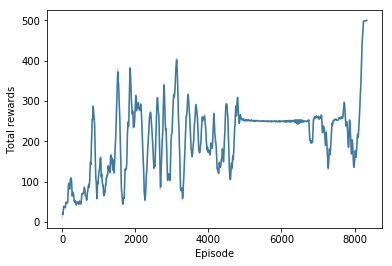

In [59]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

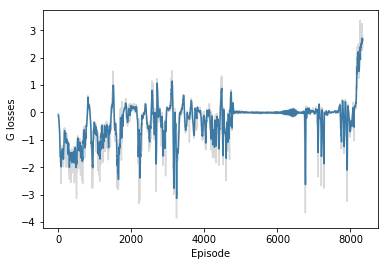

In [60]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

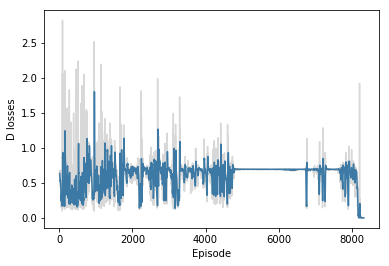

In [61]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [28]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        if total_reward == 500:
            break
                
# Closing the env
env.close()

/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model2.ckpt
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.